In [1]:
!nvidia-smi

Fri Nov 29 02:54:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   31C    P0              37W / 250W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import os 
import torch
import csv
import json
import evaluate
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
from copy import deepcopy
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchvision import transforms
from transformers import get_scheduler
from transformers import TrainingArguments
from torch.utils.data import Dataset, DataLoader, Subset
from peft import (
    PeftModel, 
    LoraConfig, 
    get_peft_model, 
    AdaLoraConfig,
    IA3Config,
    LoHaConfig,
    LoKrConfig,
)
from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    Resize, 
    ToTensor
)


2024-11-29 02:54:47.277085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 02:54:47.452036: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    parameters, trainable = 0, 0
    
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")
    

def create_label_mappings(dataset):
    label2id, id2label = dict(), dict()
    unique_labels = set([label for _, label in dataset.samples]) 
    for i, label in enumerate(unique_labels):
        label2id[label] = i
        id2label[i] = label

    return label2id, id2label


In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, load_fraction=0.1):
        self.transform = transform
        self.samples = []
        self.label2id = {}
        class_id = 0
        for class_dir in os.listdir(root_dir):
            self.label2id[class_dir] = class_id
            class_id += 1
            class_path = os.path.join(root_dir, class_dir)
            all_files = os.listdir(class_path)
            sample_count = int(len(all_files) * load_fraction)
            chosen_files = np.random.choice(all_files, sample_count, replace=False)
            for filename in chosen_files:
                self.samples.append((os.path.join(class_path, filename), class_dir))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            processed = self.transform(image)
            image = processed['pixel_values'][0]  
        return image, self.label2id[label]

    def set_transform(self, transform):
        self.transform = transform

    def get_image_path(self, idx):
        img_path, _ = self.samples[idx] 
        return img_path

def split_dataset(dataset, test_size=0.1, shuffle=True):
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, shuffle=shuffle)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])


In [7]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocess_pipeline = Compose([
    lambda image: {
        'pixel_values': torch.tensor(image_processor(image.convert("RGB")).pixel_values)
    }
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
base_dir = '/projects/academic/pedestrian_behaviour_dataset_extended_roi_2/'

action_dataset = CustomDataset(f'{base_dir}action', transform=preprocess_pipeline, load_fraction=1)
cross_dataset = CustomDataset(f'{base_dir}cross', transform=preprocess_pipeline, load_fraction=1)
look_dataset = CustomDataset(f'{base_dir}look', transform=preprocess_pipeline, load_fraction=1)
occlusion_dataset = CustomDataset(f'{base_dir}occlusion', transform=preprocess_pipeline, load_fraction=1)

action_train_dataset, action_test_dataset = split_dataset(action_dataset, test_size=0.2)
cross_train_dataset, cross_test_dataset = split_dataset(cross_dataset, test_size=0.2)
look_train_dataset, look_test_dataset = split_dataset(look_dataset, test_size=0.2)
occlusion_train_dataset, occlusion_test_dataset = split_dataset(occlusion_dataset, test_size=0.2)

print("Datasets are successfully loaded and split into training and testing sets.")

Datasets are successfully loaded and split into training and testing sets.


In [9]:
print(f"Action Dataset Size: {len(action_dataset)}")
print(f"Cross Dataset Size: {len(cross_dataset)}")
print(f"Look Dataset Size: {len(look_dataset)}")
print(f"Occlusion Dataset Size: {len(occlusion_dataset)}")

Action Dataset Size: 9000
Cross Dataset Size: 11105
Look Dataset Size: 11000
Occlusion Dataset Size: 9500


In [ ]:
output_dataset_path = "/projects/academic/pedestrian_behaviour_dataset_extended_roi_2"
behaviors = {
    "action": ["standing", "walking"],
    "look": ["looking", "not_looking"],
    "cross": ["crossing", "not_crossing"],
    "occlusion": ["no_occlusion", "partial_occlusion", "full_occlusion"]
}

# Function to count images in each class directory
def count_images_in_classes(output_path, behaviors):
    print("Image counts in each class:")
    for behavior, classes in behaviors.items():
        for class_dir in classes:
            class_path = os.path.join(output_path, behavior, class_dir)
            if os.path.exists(class_path):
                image_count = len([f for f in os.listdir(class_path) if f.endswith(".jpg")])
                print(f"{behavior}/{class_dir}: {image_count} images")
            else:
                print(f"{behavior}/{class_dir}: Directory does not exist")

# Get counts
count_images_in_classes(output_dataset_path, behaviors)


Image counts in each class:
action/standing: 4000 images
action/walking: 5000 images
look/looking: 5000 images
look/not_looking: 6000 images
cross/crossing: 6647 images
cross/not_crossing: 4458 images
occlusion/no_occlusion: 4000 images
occlusion/partial_occlusion: 3000 images
occlusion/full_occlusion: 2500 images


In [11]:
# Print dataset shapes
def print_dataset_shapes(dataset, dataset_name):
    if isinstance(dataset, Subset):
        parent_dataset = dataset.dataset
        index = dataset.indices[0]
        image, label = parent_dataset[index]
    else:
        image, label = dataset[0]
    print(f"Dataset: {dataset_name}")
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Dataset size: {len(dataset)}\n")

# Verify dataset shapes
print("Shapes for Action Dataset:")
print_dataset_shapes(action_train_dataset, "Action Train Dataset")
print_dataset_shapes(action_test_dataset, "Action Test Dataset")

print("\nShapes for Cross Dataset:")
print_dataset_shapes(cross_train_dataset, "Cross Train Dataset")
print_dataset_shapes(cross_test_dataset, "Cross Test Dataset")

print("\nShapes for Look Dataset:")
print_dataset_shapes(look_train_dataset, "Look Train Dataset")
print_dataset_shapes(look_test_dataset, "Look Test Dataset")

print("\nShapes for Occlusion Dataset:")
print_dataset_shapes(occlusion_train_dataset, "Occlusion Train Dataset")
print_dataset_shapes(occlusion_test_dataset, "Occlusion Test Dataset")

Shapes for Action Dataset:
Dataset: Action Train Dataset
Image shape: torch.Size([3, 224, 224])
Label: 0
Dataset size: 7200

Dataset: Action Test Dataset
Image shape: torch.Size([3, 224, 224])
Label: 1
Dataset size: 1800


Shapes for Cross Dataset:
Dataset: Cross Train Dataset
Image shape: torch.Size([3, 224, 224])
Label: 1
Dataset size: 8884

Dataset: Cross Test Dataset
Image shape: torch.Size([3, 224, 224])
Label: 0
Dataset size: 2221


Shapes for Look Dataset:
Dataset: Look Train Dataset
Image shape: torch.Size([3, 224, 224])
Label: 1
Dataset size: 8800

Dataset: Look Test Dataset
Image shape: torch.Size([3, 224, 224])
Label: 0
Dataset size: 2200


Shapes for Occlusion Dataset:
Dataset: Occlusion Train Dataset
Image shape: torch.Size([3, 224, 224])
Label: 2
Dataset size: 7600

Dataset: Occlusion Test Dataset
Image shape: torch.Size([3, 224, 224])
Label: 0
Dataset size: 1900



In [12]:
action_dataset_id2label = {v: k for k, v in action_dataset.label2id.items()}
action_dataset_label2id = action_dataset.label2id

cross_dataset_id2label = {v: k for k, v in cross_dataset.label2id.items()}
cross_dataset_label2id = cross_dataset.label2id

look_dataset_id2label = {v: k for k, v in look_dataset.label2id.items()}
look_dataset_label2id = look_dataset.label2id

occlusion_dataset_id2label = {v: k for k, v in occlusion_dataset.label2id.items()}
occlusion_dataset_label2id = occlusion_dataset.label2id

# Print label mappings for each dataset
print("Action Dataset Label to ID Mapping:", action_dataset_id2label)
print("\nCross Dataset Label to ID Mapping:", cross_dataset_id2label)
print("\nLook Dataset Label to ID Mapping:", look_dataset_id2label)
print("\nOcclusion Dataset Label to ID Mapping:", occlusion_dataset_id2label)


Action Dataset Label to ID Mapping: {0: 'standing', 1: 'walking'}

Cross Dataset Label to ID Mapping: {0: 'crossing', 1: 'not_crossing'}

Look Dataset Label to ID Mapping: {0: 'looking', 1: 'not_looking'}

Occlusion Dataset Label to ID Mapping: {0: 'full_occlusion', 1: 'no_occlusion', 2: 'partial_occlusion'}


In [ ]:
from torch.utils.data import DataLoader

def check_unique_labels(dataset, id2label, batch_size=64):
    unique_labels = set()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in dataloader:
        _, labels = batch  
        unique_labels.update(labels.tolist())

        if len(unique_labels) == len(id2label):
            break

    print("Unique labels in the dataset:")
    for label in unique_labels:
        print(f"Label {label}: {id2label.get(label, 'Unknown label')}")

print("Unique labels in action_train_dataset:")
check_unique_labels(action_train_dataset, action_dataset_id2label)

print("\nUnique labels in action_test_dataset:")
check_unique_labels(action_test_dataset, action_dataset_id2label)

print("\nUnique labels in cross_train_dataset:")
check_unique_labels(cross_train_dataset, cross_dataset_id2label)

print("\nUnique labels in cross_test_dataset:")
check_unique_labels(cross_test_dataset, cross_dataset_id2label)

print("\nUnique labels in look_train_dataset:")
check_unique_labels(look_train_dataset, look_dataset_id2label)

print("\nUnique labels in look_test_dataset:")
check_unique_labels(look_test_dataset, look_dataset_id2label)

print("\nUnique labels in occlusion_train_dataset:")
check_unique_labels(occlusion_train_dataset, occlusion_dataset_id2label)

print("\nUnique labels in occlusion_test_dataset:")
check_unique_labels(occlusion_test_dataset, occlusion_dataset_id2label)


Unique labels in action_train_dataset:
Unique labels in the dataset:
Label 0: standing
Label 1: walking

Unique labels in action_test_dataset:
Unique labels in the dataset:
Label 0: standing
Label 1: walking

Unique labels in cross_train_dataset:
Unique labels in the dataset:
Label 0: crossing
Label 1: not_crossing

Unique labels in cross_test_dataset:
Unique labels in the dataset:
Label 0: crossing
Label 1: not_crossing

Unique labels in look_train_dataset:
Unique labels in the dataset:
Label 0: looking
Label 1: not_looking

Unique labels in look_test_dataset:
Unique labels in the dataset:
Label 0: looking
Label 1: not_looking

Unique labels in occlusion_train_dataset:
Unique labels in the dataset:
Label 0: full_occlusion
Label 1: no_occlusion
Label 2: partial_occlusion

Unique labels in occlusion_test_dataset:
Unique labels in the dataset:
Label 0: full_occlusion
Label 1: no_occlusion
Label 2: partial_occlusion


In [14]:
config_ped = {
    "ACTION_ADAPTER_MODEL": {
        "train_data": action_train_dataset,
        "test_data": action_test_dataset,
        "label2id": action_dataset_label2id,
        "id2label": action_dataset_id2label,
        "epochs": 5,  
        "path": "./lora-action-model",
    },
    "CROSS_ADAPTER_MODEL": {
        "train_data": cross_train_dataset,
        "test_data": cross_test_dataset,
        "label2id": cross_dataset_label2id,
        "id2label": cross_dataset_id2label,
        "epochs": 5, 
        "path": "./lora-cross-model",
    },
    "LOOK_ADAPTER_MODEL": {
        "train_data": look_train_dataset,
        "test_data": look_test_dataset,
        "label2id": look_dataset_label2id,
        "id2label": look_dataset_id2label,
        "epochs": 5, 
        "path": "./lora-look-model",
    },
    "OCCLUSION_ADAPTER_MODEL": {
        "train_data": occlusion_train_dataset,
        "test_data": occlusion_test_dataset,
        "label2id": occlusion_dataset_label2id,
        "id2label": occlusion_dataset_id2label,
        "epochs": 5, 
        "path": "./lora-occlusion-model",
    }
}


In [15]:
adapter_configs = {
    "lora": {
        "peft_type": "LORA",
        "config": LoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,
            lora_alpha=32,
            target_modules=["query", "value", "key"],  
            lora_dropout=0.2,
            bias="none",
            modules_to_save=["classifier"],
        )
    },

    "adalora": {
        "peft_type": "ADALORA",
        "config": AdaLoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            init_r=8,  
            lora_alpha=32,  
            target_modules=["query", "value", "key"],  
            lora_dropout=0.2,
            modules_to_save=["classifier"],
        )
    },

    "ia3": {
        "peft_type": "IA3",
        "config": IA3Config(
            task_type="IMAGE_CLASSIFICATION",
            target_modules=["query", "value", "key", "output.dense", "intermediate.dense"],  
            feedforward_modules=["output.dense", "intermediate.dense"],   
            modules_to_save=["classifier"],
        )
    },

    "loha": {
        "peft_type": "LOHA",
        "config": LoHaConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  
            alpha=32,  
            target_modules=["query", "value", "key"],  
            modules_to_save=["classifier"],
        )
    },

    "lokr": {
        "peft_type": "LOKR",
        "config": LoKrConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  
            alpha=32,  
            target_modules=["query", "value", "key"],  
            modules_to_save=["classifier"],
        )
    }
}

In [16]:
metric = evaluate.load("accuracy")
metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def data_collate(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)["accuracy"]
    f1 = metric_f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["f1"]
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

metrics_storage = {
    adapter_type: {
        lora_type: {
            "train_accuracy": [],  
            "eval_accuracy": [],   
            "train_loss": [],      
            "eval_loss": [],       
            "eval_f1": [],         
            "eval_precision": [],  
            "eval_recall": []      
        }
        for lora_type in adapter_configs.keys()
    }
    for adapter_type in config_ped.keys()  
}

def get_base_model(label2id, id2label):
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True).to(device)


In [17]:
batch_size = 64

In [18]:
def get_training_arguments(epochs):
    return TrainingArguments(
        output_dir="./model-checkpoints",
        weight_decay=0.01,
        remove_unused_columns=False,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=5e-4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=4,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        label_names=["labels"],
        num_train_epochs=epochs,  
        save_total_limit=2,
        logging_dir='./logs',
        disable_tqdm=True,
        max_grad_norm=1.0
    )

In [19]:
class LoggingCallback(TrainerCallback):
    def __init__(self, adapter_type, lora_type, model, train_dataloader):
        self.adapter_type = adapter_type
        self.lora_type = lora_type
        self.model_name = f"{adapter_type}_{lora_type}"
        self.model = model
        self.train_dataloader = train_dataloader
        self.current_epoch = 1 
        
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting Epoch {self.current_epoch}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            metrics = metrics_storage[self.adapter_type][self.lora_type]
            if "eval_loss" in logs:
                metrics["eval_loss"].append(logs["eval_loss"])
                metrics["eval_accuracy"].append(logs.get("eval_accuracy", 0))
                metrics["eval_f1"].append(logs.get("eval_f1", 0))
                metrics["eval_precision"].append(logs.get("eval_precision", 0))
                metrics["eval_recall"].append(logs.get("eval_recall", 0))
            if "loss" in logs:
                metrics["train_loss"].append(logs["loss"])

    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Epoch {self.current_epoch} ending")
        train_accuracy = self.compute_train_accuracy()
        metrics_storage[self.adapter_type][self.lora_type]["train_accuracy"].append(train_accuracy)
        
        print(f"Completed Epoch {self.current_epoch}")
        self.current_epoch += 1

    def compute_train_accuracy(self):
        train_dataloader = DataLoader(
            config_ped[self.adapter_type]["train_data"],
            batch_size=batch_size,
            collate_fn=data_collate
        )
        correct = 0
        total = 0
        self.model.eval()

        with torch.no_grad():
            for batch in train_dataloader:
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = self.model(pixel_values=pixel_values)
                preds = outputs.logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return correct / total if total > 0 else 0

    def on_train_end(self, args, state, control, **kwargs):
        print(f"\nTraining completed for {self.model_name}. Final Metrics:")

        metrics = metrics_storage[self.adapter_type][self.lora_type]
        max_length = max(len(metrics[key]) for key in metrics)

        for key in metrics:
            metrics[key].extend([None] * (max_length - len(metrics[key])))

        metrics_data = {
            "Epoch": list(range(1, max_length + 1)),
            "Train Accuracy": metrics["train_accuracy"],
            "Eval Accuracy": metrics["eval_accuracy"],
            "Train Loss": metrics["train_loss"],
            "Eval Loss": metrics["eval_loss"],
            "F1": metrics["eval_f1"],
            "Precision": metrics["eval_precision"],
            "Recall": metrics["eval_recall"]
        }

        metrics_df = pd.DataFrame(metrics_data)
        print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

        self.plot_metrics()

    def plot_metrics(self):
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        train_loss = metrics["train_loss"]
        eval_loss = metrics["eval_loss"]
        eval_accuracy = metrics["eval_accuracy"]
        train_accuracy = metrics["train_accuracy"]

        min_len = min(len(train_loss), len(eval_loss), len(eval_accuracy), len(train_accuracy))
        epochs = list(range(1, min_len + 1))

        train_loss = train_loss[:min_len]
        eval_loss = eval_loss[:min_len]
        eval_accuracy = eval_accuracy[:min_len]
        train_accuracy = train_accuracy[:min_len]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label="Train Loss", marker="o")
        plt.plot(epochs, eval_loss, label="Eval Loss", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss per Epoch for {self.model_name}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
        plt.plot(epochs, eval_accuracy, label="Eval Accuracy", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy per Epoch for {self.model_name}")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [20]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

def build_adapter_model(adapter_type, label2id, id2label):
    base_model = get_base_model(label2id, id2label).to(device)
    config = adapter_configs[adapter_type]["config"]
    adapter_model = get_peft_model(base_model, config).to(device)
    print_trainable_parameters(adapter_model, label=f"{adapter_type} Adapter")
    return adapter_model

def train_model_with_adapter(adapter_type, lora_type):
    config_data = config_ped[adapter_type]
    model = build_adapter_model(lora_type, config_data["label2id"], config_data["id2label"])
    optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
    total_train_steps = len(config_data["train_data"]) // batch_size * config_data["epochs"]
    
    print("Number of Training Epochs: ", config_data["epochs"])
    model_training_args = get_training_arguments(config_data["epochs"])

    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_train_steps
    )

    train_dataloader = DataLoader(
        config_data["train_data"], batch_size=batch_size
    )

    trainer = Trainer(
        model=model,
        args=model_training_args,
        train_dataset=config_data["train_data"],
        eval_dataset=config_data["test_data"],
        data_collator=data_collate,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks=[LoggingCallback(adapter_type, lora_type, model, train_dataloader)]  
    )

    trainer.train()
    metrics = trainer.evaluate()
    save_dir = './ped_behavior_filtered_v1/'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{adapter_type}_{lora_type}")
    trainer.save_model(model_path)
    mappings = {
        "label2id": config_data["label2id"],
        "id2label": config_data["id2label"]
    }
    mappings_path = os.path.join(model_path, "mappings.json")
    with open(mappings_path, "w") as f:
        json.dump(mappings, f, indent=4)
    adapter_configs[lora_type]["class_mappings"] = mappings
    return metrics



Training ACTION_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 443,906/86,244,100 (0.51%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.3163, 'grad_norm': 2.600149393081665, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 0.324009507894516, 'eval_accuracy': 0.8511111111111112, 'eval_f1': 0.849511334875122, 'eval_precision': 0.8534118028341585, 'eval_recall': 0.8511111111111112, 'eval_runtime': 32.8199, 'eval_samples_per_second': 54.845, 'eval_steps_per_second': 0.884, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 0.9217, 'grad_norm': 2.0655324459075928, 'learning_rate': 0.0027500000000000003, 'epoch': 1.9823008849557522}
{'eval_loss': 0.1599419116973877, 'eval_accuracy': 0.9338888888888889, 'eval_f1': 0.9338215503948658, 'eval_precision': 0.9338534627529114, 'eval_recall': 0.9338888888888889, 'eval_runtime': 30.8047, 'eval_samples_per_second': 58.433, 'eval_steps_per_second': 0.941, 'epoch': 1

Could not locate the best model at ./model-checkpoints/checkpoint-84/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.19939997792243958, 'eval_accuracy': 0.9188888888888889, 'eval_f1': 0.9189572395774116, 'eval_precision': 0.9191081943825432, 'eval_recall': 0.9188888888888889, 'eval_runtime': 30.7726, 'eval_samples_per_second': 58.494, 'eval_steps_per_second': 0.942, 'epoch': 4.95575221238938}
{'train_runtime': 1444.5923, 'train_samples_per_second': 24.921, 'train_steps_per_second': 0.097, 'train_loss': 0.9374612127031599, 'epoch': 4.95575221238938}

Training completed for ACTION_ADAPTER_MODEL_lora. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.853889 |        0.851111 |       2.3163 |    0.32401  | 0.849511 |    0.853412 | 0.851111 |
+---

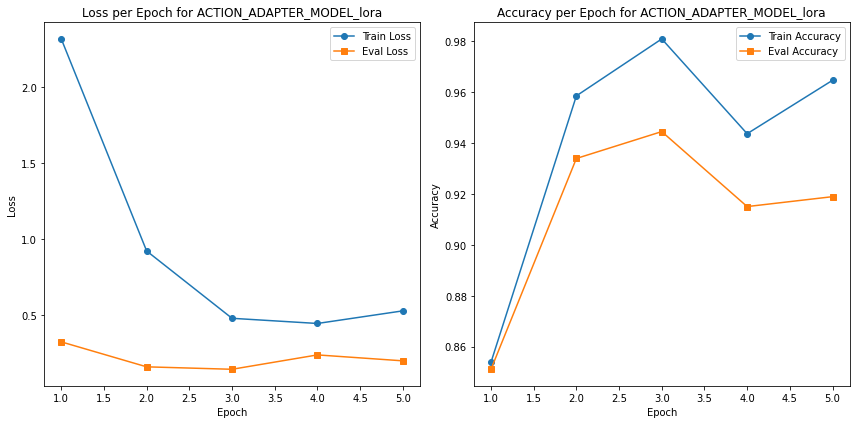

{'eval_loss': 0.19939997792243958, 'eval_accuracy': 0.9188888888888889, 'eval_f1': 0.9189572395774116, 'eval_precision': 0.9191081943825432, 'eval_recall': 0.9188888888888889, 'eval_runtime': 30.9089, 'eval_samples_per_second': 58.236, 'eval_steps_per_second': 0.938, 'epoch': 4.95575221238938}

Training ACTION_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 444,194/86,244,424 (0.52%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5613, 'grad_norm': 1.1515650749206543, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 0.5271782279014587, 'eval_accuracy': 0.7511111111111111, 'eval_f1': 0.741299132249913, 'eval_precision': 0.7628770834645338, 'eval_recall': 0.7511111111111111, 'eval_runtime': 31.0567, 'eval_samples_per_second': 57.959, 'eval_steps_per_second': 0.934, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.5258, 'grad_norm': 1.0465646982192993, 'learning_rate': 0.0027500000000000003, 'epoch': 1.9823008849557522}
{'eval_loss': 0.2590695321559906, 'eval_accuracy': 0.8916666666666667, 'eval_f1': 0.8920486319891696, 'eval_precision': 0.8949050593324985, 'eval_recall': 0.8916666666666667, 'eval_runtime': 31.0537, 'eval_samples_per_second': 57.964, 'eval_steps_per_second': 0.934, 'epoc

Could not locate the best model at ./model-checkpoints/checkpoint-113/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.1804492175579071, 'eval_accuracy': 0.94, 'eval_f1': 0.9402057303477181, 'eval_precision': 0.9427944551000887, 'eval_recall': 0.94, 'eval_runtime': 31.1448, 'eval_samples_per_second': 57.795, 'eval_steps_per_second': 0.931, 'epoch': 4.95575221238938}
{'train_runtime': 1447.6049, 'train_samples_per_second': 24.869, 'train_steps_per_second': 0.097, 'train_loss': 1.0661225966044834, 'epoch': 4.95575221238938}

Training completed for ACTION_ADAPTER_MODEL_adalora. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.748333 |        0.751111 |       2.5613 |    0.527178 | 0.741299 |    0.762877 | 0.751111 |
+----+---------+--------------

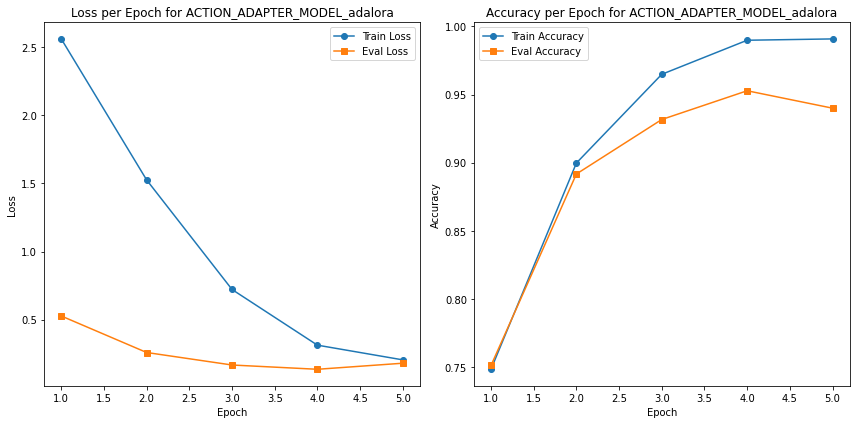

{'eval_loss': 0.1804492175579071, 'eval_accuracy': 0.94, 'eval_f1': 0.9402057303477181, 'eval_precision': 0.9427944551000887, 'eval_recall': 0.94, 'eval_runtime': 31.2309, 'eval_samples_per_second': 57.635, 'eval_steps_per_second': 0.929, 'epoch': 4.95575221238938}

Training ACTION_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 84,482/85,884,676 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.527, 'grad_norm': 1.2245543003082275, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 0.5071281790733337, 'eval_accuracy': 0.7561111111111111, 'eval_f1': 0.7493999003425147, 'eval_precision': 0.7619068442556887, 'eval_recall': 0.7561111111111111, 'eval_runtime': 31.3542, 'eval_samples_per_second': 57.409, 'eval_steps_per_second': 0.925, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.5761, 'grad_norm': 0.6484420299530029, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 0.2993340492248535, 'eval_accuracy': 0.8683333333333333, 'eval_f1': 0.8680624765320493, 'eval_precision': 0.8681329557347572, 'eval_recall': 0.8683333333333333, 'eval_runtime': 31.3735, 'eval_samples_per_second': 57.373, 'eval_steps_per_second': 0.924, 'epoch': 1

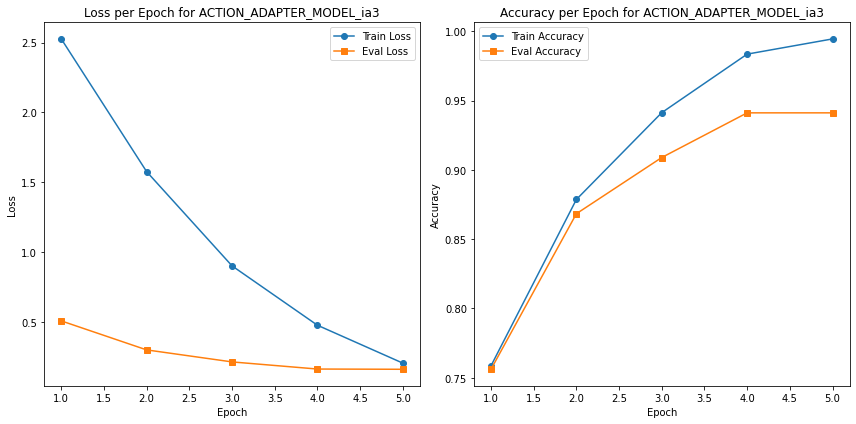

{'eval_loss': 0.16220825910568237, 'eval_accuracy': 0.9411111111111111, 'eval_f1': 0.9411607355836004, 'eval_precision': 0.94129502859696, 'eval_recall': 0.9411111111111111, 'eval_runtime': 31.3814, 'eval_samples_per_second': 57.359, 'eval_steps_per_second': 0.924, 'epoch': 4.95575221238938}

Training ACTION_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 886,274/86,686,468 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5477, 'grad_norm': nan, 'learning_rate': 0.00135, 'epoch': 0.9911504424778761}
{'eval_loss': 0.5263682007789612, 'eval_accuracy': 0.7522222222222222, 'eval_f1': 0.7418123580134244, 'eval_precision': 0.7657193726666839, 'eval_recall': 0.7522222222222222, 'eval_runtime': 31.8715, 'eval_samples_per_second': 56.477, 'eval_steps_per_second': 0.91, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.5438, 'grad_norm': 0.647419273853302, 'learning_rate': 0.0027, 'epoch': 1.9823008849557522}
{'eval_loss': 0.2694146931171417, 'eval_accuracy': 0.8877777777777778, 'eval_f1': 0.8882489712164132, 'eval_precision': 0.8939807861220904, 'eval_recall': 0.8877777777777778, 'eval_runtime': 31.0715, 'eval_samples_per_second': 57.931, 'eval_steps_per_second': 0.933, 'epoch': 1.9823008849557522}
Starting Epoch 3
Epoch 3

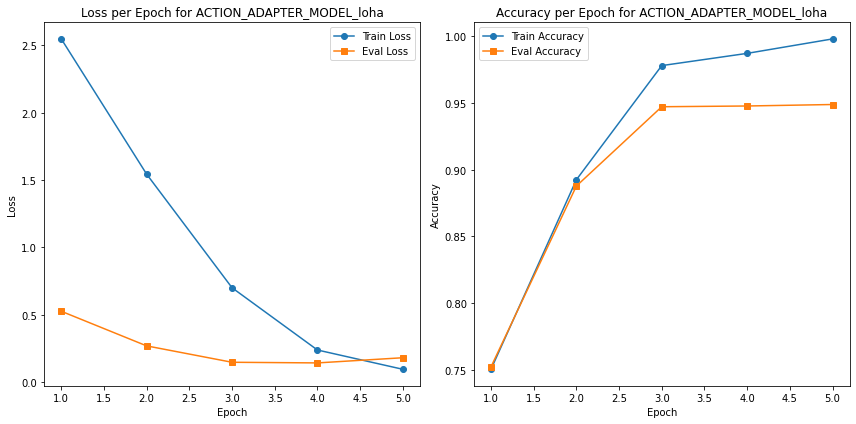

{'eval_loss': 0.1814444661140442, 'eval_accuracy': 0.9488888888888889, 'eval_f1': 0.9490189344843719, 'eval_precision': 0.9501884604841989, 'eval_recall': 0.9488888888888889, 'eval_runtime': 31.0027, 'eval_samples_per_second': 58.06, 'eval_steps_per_second': 0.935, 'epoch': 4.95575221238938}

Training ACTION_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 40,706/85,840,900 (0.05%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.6006, 'grad_norm': 1.145475149154663, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 0.5416233539581299, 'eval_accuracy': 0.7516666666666667, 'eval_f1': 0.7399518431821724, 'eval_precision': 0.7684065923169975, 'eval_recall': 0.7516666666666667, 'eval_runtime': 31.1652, 'eval_samples_per_second': 57.757, 'eval_steps_per_second': 0.931, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.8127, 'grad_norm': 0.5392983555793762, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 0.3607834577560425, 'eval_accuracy': 0.8244444444444444, 'eval_f1': 0.8241304461998498, 'eval_precision': 0.8240665204678362, 'eval_recall': 0.8244444444444444, 'eval_runtime': 31.2614, 'eval_samples_per_second': 57.579, 'eval_steps_per_second': 0.928, 'epoch': 

Could not locate the best model at ./model-checkpoints/checkpoint-113/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.16923333704471588, 'eval_accuracy': 0.9411111111111111, 'eval_f1': 0.9412915858160887, 'eval_precision': 0.9431727958775349, 'eval_recall': 0.9411111111111111, 'eval_runtime': 31.0831, 'eval_samples_per_second': 57.909, 'eval_steps_per_second': 0.933, 'epoch': 4.95575221238938}
{'train_runtime': 1440.23, 'train_samples_per_second': 24.996, 'train_steps_per_second': 0.097, 'train_loss': 1.2677053553717477, 'epoch': 4.95575221238938}

Training completed for ACTION_ADAPTER_MODEL_lokr. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.744861 |        0.751667 |       2.6006 |    0.541623 | 0.739952 |    0.768407 | 0.751667 |
+----+

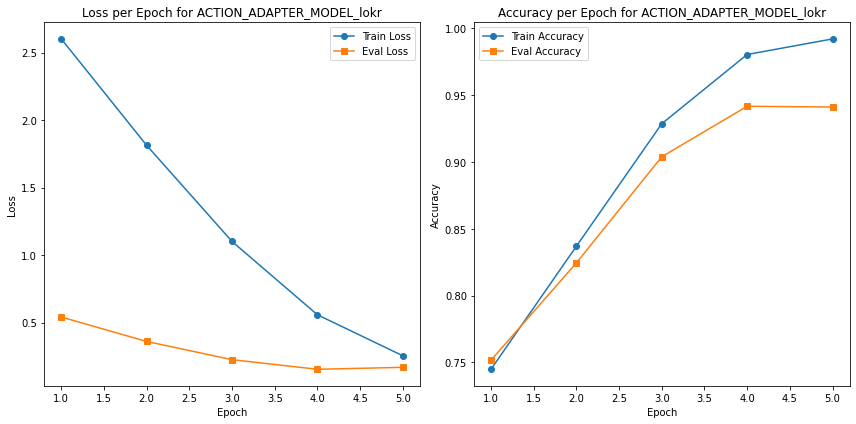

{'eval_loss': 0.16923333704471588, 'eval_accuracy': 0.9411111111111111, 'eval_f1': 0.9412915858160887, 'eval_precision': 0.9431727958775349, 'eval_recall': 0.9411111111111111, 'eval_runtime': 31.0401, 'eval_samples_per_second': 57.99, 'eval_steps_per_second': 0.934, 'epoch': 4.95575221238938}

Training CROSS_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 443,906/86,244,100 (0.51%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.3332, 'grad_norm': 3.0076732635498047, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9784172661870504}
{'eval_loss': 0.40756314992904663, 'eval_accuracy': 0.8176497073390365, 'eval_f1': 0.8149281378222581, 'eval_precision': 0.8182596407044853, 'eval_recall': 0.8176497073390365, 'eval_runtime': 40.5641, 'eval_samples_per_second': 54.753, 'eval_steps_per_second': 0.863, 'epoch': 0.9784172661870504}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.2561, 'grad_norm': 2.30859375, 'learning_rate': 0.0034000000000000002, 'epoch': 1.985611510791367}
{'eval_loss': 0.24701328575611115, 'eval_accuracy': 0.9027465105808195, 'eval_f1': 0.9030871861386022, 'eval_precision': 0.9042827345719489, 'eval_recall': 0.9027465105808195, 'eval_runtime': 38.25, 'eval_samples_per_second': 58.065, 'eval_steps_per_second': 0.915, 'epoch': 1.98561

Could not locate the best model at ./model-checkpoints/checkpoint-104/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.2435063123703003, 'eval_accuracy': 0.9045475011256191, 'eval_f1': 0.9050962578842016, 'eval_precision': 0.908634139386053, 'eval_recall': 0.9045475011256191, 'eval_runtime': 37.674, 'eval_samples_per_second': 58.953, 'eval_steps_per_second': 0.929, 'epoch': 4.892086330935252}
{'train_runtime': 1761.9291, 'train_samples_per_second': 25.211, 'train_steps_per_second': 0.096, 'train_loss': 1.1953570758595187, 'epoch': 4.892086330935252}

Training completed for CROSS_ADAPTER_MODEL_lora. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.834759 |        0.81765  |       2.3332 |    0.407563 | 0.814928 |    0.81826  | 0.81765  |
+----+

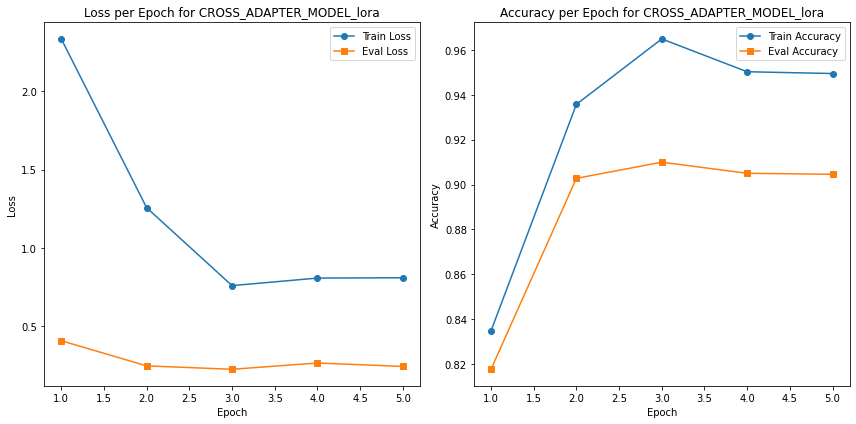

{'eval_loss': 0.2435063123703003, 'eval_accuracy': 0.9045475011256191, 'eval_f1': 0.9050962578842016, 'eval_precision': 0.908634139386053, 'eval_recall': 0.9045475011256191, 'eval_runtime': 38.1394, 'eval_samples_per_second': 58.234, 'eval_steps_per_second': 0.918, 'epoch': 4.892086330935252}

Training CROSS_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 444,194/86,244,424 (0.52%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.6267, 'grad_norm': 0.8567717671394348, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9784172661870504}
{'eval_loss': 0.5485415458679199, 'eval_accuracy': 0.720396217919856, 'eval_f1': 0.716701229492333, 'eval_precision': 0.7172887765126854, 'eval_recall': 0.720396217919856, 'eval_runtime': 38.7221, 'eval_samples_per_second': 57.357, 'eval_steps_per_second': 0.904, 'epoch': 0.9784172661870504}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.6365, 'grad_norm': 1.1576429605484009, 'learning_rate': 0.00335, 'epoch': 1.985611510791367}
{'eval_loss': 0.33138418197631836, 'eval_accuracy': 0.8590724898694282, 'eval_f1': 0.8576619539118808, 'eval_precision': 0.8595694026680134, 'eval_recall': 0.8590724898694282, 'eval_runtime': 38.7038, 'eval_samples_per_second': 57.385, 'eval_steps_per_second': 0.904, 'epoch': 1.9856115107

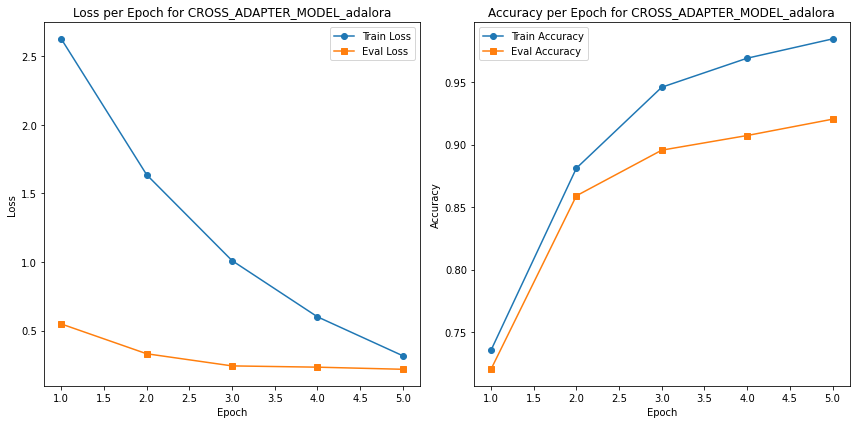

{'eval_loss': 0.21819013357162476, 'eval_accuracy': 0.9203061683926159, 'eval_f1': 0.9200350973374589, 'eval_precision': 0.920295244147467, 'eval_recall': 0.9203061683926159, 'eval_runtime': 38.8317, 'eval_samples_per_second': 57.196, 'eval_steps_per_second': 0.901, 'epoch': 4.892086330935252}

Training CROSS_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 84,482/85,884,676 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5935, 'grad_norm': 0.8824817538261414, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9784172661870504}
{'eval_loss': 0.5352718830108643, 'eval_accuracy': 0.7334533993696533, 'eval_f1': 0.7309541629657472, 'eval_precision': 0.7309348055994918, 'eval_recall': 0.7334533993696533, 'eval_runtime': 38.8894, 'eval_samples_per_second': 57.111, 'eval_steps_per_second': 0.9, 'epoch': 0.9784172661870504}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.7239, 'grad_norm': nan, 'learning_rate': 0.00335, 'epoch': 1.985611510791367}
{'eval_loss': 0.37671226263046265, 'eval_accuracy': 0.824853669518235, 'eval_f1': 0.8247187374040674, 'eval_precision': 0.8246114631760412, 'eval_recall': 0.824853669518235, 'eval_runtime': 39.1469, 'eval_samples_per_second': 56.735, 'eval_steps_per_second': 0.894, 'epoch': 1.985611510791367}
Starting Epoch

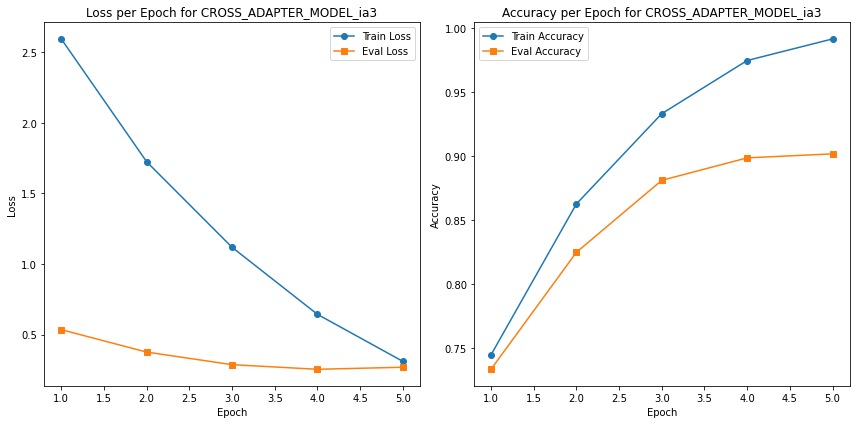

{'eval_loss': 0.2693405747413635, 'eval_accuracy': 0.9018460153084197, 'eval_f1': 0.9020586495245058, 'eval_precision': 0.9025631916407353, 'eval_recall': 0.9018460153084197, 'eval_runtime': 38.7826, 'eval_samples_per_second': 57.268, 'eval_steps_per_second': 0.902, 'epoch': 4.892086330935252}

Training CROSS_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 886,274/86,686,468 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.6146, 'grad_norm': 0.8527941107749939, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9784172661870504}
{'eval_loss': 0.545121967792511, 'eval_accuracy': 0.7239981990094552, 'eval_f1': 0.7211649379746914, 'eval_precision': 0.7211749601690935, 'eval_recall': 0.7239981990094552, 'eval_runtime': 39.1137, 'eval_samples_per_second': 56.783, 'eval_steps_per_second': 0.895, 'epoch': 0.9784172661870504}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.611, 'grad_norm': 0.553196370601654, 'learning_rate': 0.0034000000000000002, 'epoch': 1.985611510791367}
{'eval_loss': 0.3087424635887146, 'eval_accuracy': 0.8671769473210266, 'eval_f1': 0.8676830029792584, 'eval_precision': 0.8691871050374214, 'eval_recall': 0.8671769473210266, 'eval_runtime': 38.2747, 'eval_samples_per_second': 58.028, 'eval_steps_per_second': 0.914, 'epoch': 1.

Could not locate the best model at ./model-checkpoints/checkpoint-139/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.2690879702568054, 'eval_accuracy': 0.9149031967582171, 'eval_f1': 0.9154319382983769, 'eval_precision': 0.9197638805846007, 'eval_recall': 0.9149031967582171, 'eval_runtime': 38.3316, 'eval_samples_per_second': 57.942, 'eval_steps_per_second': 0.913, 'epoch': 4.892086330935252}
{'train_runtime': 1767.339, 'train_samples_per_second': 25.134, 'train_steps_per_second': 0.096, 'train_loss': 1.138539732203764, 'epoch': 4.892086330935252}

Training completed for CROSS_ADAPTER_MODEL_loha. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.741558 |        0.723998 |       2.6146 |    0.545122 | 0.721165 |    0.721175 | 0.723998 |
+----+

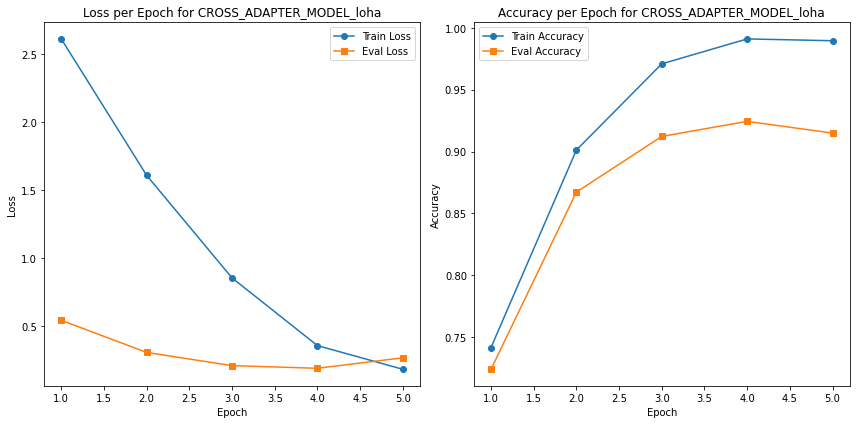

{'eval_loss': 0.2690879702568054, 'eval_accuracy': 0.9149031967582171, 'eval_f1': 0.9154319382983769, 'eval_precision': 0.9197638805846007, 'eval_recall': 0.9149031967582171, 'eval_runtime': 38.597, 'eval_samples_per_second': 57.543, 'eval_steps_per_second': 0.907, 'epoch': 4.892086330935252}

Training CROSS_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 40,706/85,840,900 (0.05%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5949, 'grad_norm': 0.9454023838043213, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9784172661870504}
{'eval_loss': 0.5596843957901001, 'eval_accuracy': 0.7239981990094552, 'eval_f1': 0.7201957067037372, 'eval_precision': 0.7210015735628642, 'eval_recall': 0.7239981990094552, 'eval_runtime': 38.7885, 'eval_samples_per_second': 57.259, 'eval_steps_per_second': 0.902, 'epoch': 0.9784172661870504}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.9014, 'grad_norm': nan, 'learning_rate': 0.00335, 'epoch': 1.985611510791367}
{'eval_loss': 0.41323742270469666, 'eval_accuracy': 0.809995497523638, 'eval_f1': 0.8097648080474136, 'eval_precision': 0.8095998151568516, 'eval_recall': 0.809995497523638, 'eval_runtime': 38.5266, 'eval_samples_per_second': 57.648, 'eval_steps_per_second': 0.908, 'epoch': 1.985611510791367}
Starting Ep

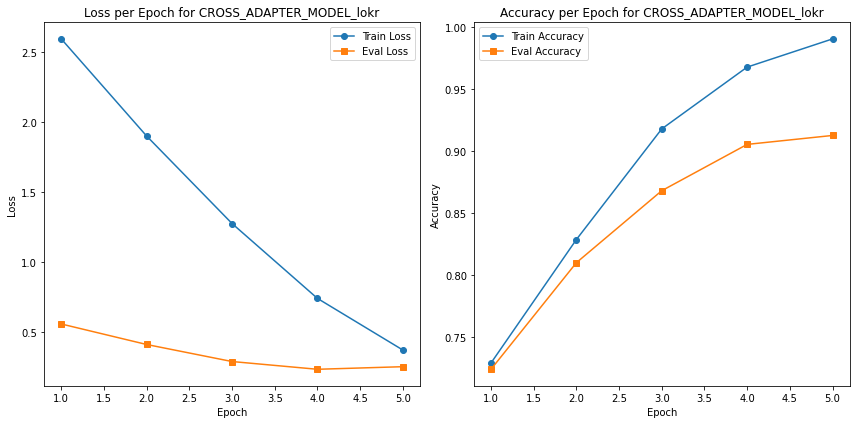

{'eval_loss': 0.25475823879241943, 'eval_accuracy': 0.9126519585772175, 'eval_f1': 0.9125459070170574, 'eval_precision': 0.9125146400769693, 'eval_recall': 0.9126519585772175, 'eval_runtime': 38.4562, 'eval_samples_per_second': 57.754, 'eval_steps_per_second': 0.91, 'epoch': 4.892086330935252}

Training LOOK_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 443,906/86,244,100 (0.51%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.304, 'grad_norm': 4.156078815460205, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9855072463768116}
{'eval_loss': 0.37296175956726074, 'eval_accuracy': 0.8281818181818181, 'eval_f1': 0.8282607504718741, 'eval_precision': 0.828406908757701, 'eval_recall': 0.8281818181818181, 'eval_runtime': 40.0267, 'eval_samples_per_second': 54.963, 'eval_steps_per_second': 0.874, 'epoch': 0.9855072463768116}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.2321, 'grad_norm': 1.9114420413970947, 'learning_rate': 0.00345, 'epoch': 2.0}
{'eval_loss': 0.27642571926116943, 'eval_accuracy': 0.8809090909090909, 'eval_f1': 0.8803727100904082, 'eval_precision': 0.8824562772761909, 'eval_recall': 0.8809090909090909, 'eval_runtime': 37.2959, 'eval_samples_per_second': 58.988, 'eval_steps_per_second': 0.938, 'epoch': 2.0}
Starting Epoch 3
Epoch 

Could not locate the best model at ./model-checkpoints/checkpoint-103/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'train_runtime': 1743.1124, 'train_samples_per_second': 25.242, 'train_steps_per_second': 0.098, 'train_loss': 1.3166018766515395, 'epoch': 4.927536231884058}

Training completed for LOOK_ADAPTER_MODEL_lora. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.852614 |        0.828182 |       2.304  |    0.372962 | 0.828261 |    0.828407 | 0.828182 |
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|  1 |       2 |         0.921136 |        0.880909 |       1.2321 |    0.276426 | 0.880373 |    0.882456 | 0.880909 |
+----+---------+------------------+-----------------+---------

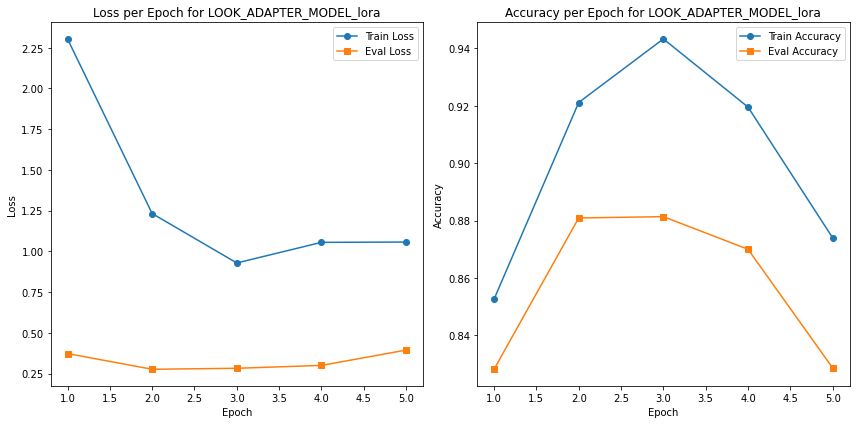

{'eval_loss': 0.3943842649459839, 'eval_accuracy': 0.8286363636363636, 'eval_f1': 0.824630299329663, 'eval_precision': 0.8447388314548802, 'eval_recall': 0.8286363636363636, 'eval_runtime': 37.8094, 'eval_samples_per_second': 58.187, 'eval_steps_per_second': 0.926, 'epoch': 4.927536231884058}

Training LOOK_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 444,194/86,244,424 (0.52%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.578, 'grad_norm': 0.958319365978241, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9855072463768116}
{'eval_loss': 0.5417843461036682, 'eval_accuracy': 0.7113636363636363, 'eval_f1': 0.7011049407369032, 'eval_precision': 0.7252980586144115, 'eval_recall': 0.7113636363636363, 'eval_runtime': 37.7163, 'eval_samples_per_second': 58.33, 'eval_steps_per_second': 0.928, 'epoch': 0.9855072463768116}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.5458, 'grad_norm': 1.3896085023880005, 'learning_rate': 0.00345, 'epoch': 2.0}
{'eval_loss': 0.341092586517334, 'eval_accuracy': 0.8472727272727273, 'eval_f1': 0.8455895669083299, 'eval_precision': 0.8530043783124975, 'eval_recall': 0.8472727272727273, 'eval_runtime': 37.8976, 'eval_samples_per_second': 58.051, 'eval_steps_per_second': 0.924, 'epoch': 2.0}
Starting Epoch 3
Epoch 

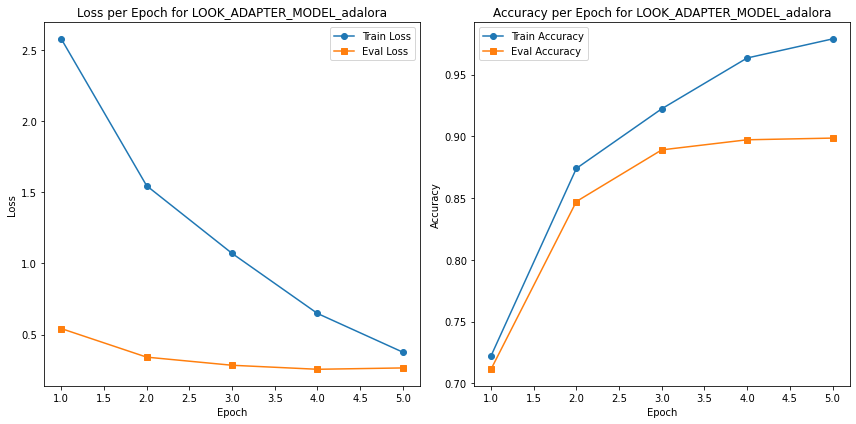

{'eval_loss': 0.2651912569999695, 'eval_accuracy': 0.8986363636363637, 'eval_f1': 0.8981126268105843, 'eval_precision': 0.9008750659557606, 'eval_recall': 0.8986363636363637, 'eval_runtime': 37.7184, 'eval_samples_per_second': 58.327, 'eval_steps_per_second': 0.928, 'epoch': 4.927536231884058}

Training LOOK_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 84,482/85,884,676 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.552, 'grad_norm': 0.974245011806488, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9855072463768116}
{'eval_loss': 0.537852942943573, 'eval_accuracy': 0.7181818181818181, 'eval_f1': 0.7071334173128789, 'eval_precision': 0.7355108084329798, 'eval_recall': 0.7181818181818181, 'eval_runtime': 38.0353, 'eval_samples_per_second': 57.841, 'eval_steps_per_second': 0.92, 'epoch': 0.9855072463768116}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.659, 'grad_norm': 0.803271472454071, 'learning_rate': 0.00345, 'epoch': 2.0}
{'eval_loss': 0.36793556809425354, 'eval_accuracy': 0.83, 'eval_f1': 0.8294198728671797, 'eval_precision': 0.8304482569098125, 'eval_recall': 0.83, 'eval_runtime': 38.0599, 'eval_samples_per_second': 57.804, 'eval_steps_per_second': 0.92, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss':

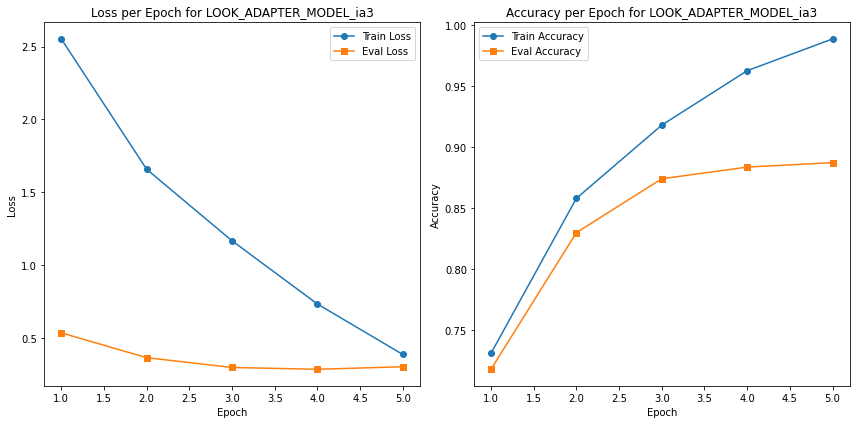

{'eval_loss': 0.30567577481269836, 'eval_accuracy': 0.8872727272727273, 'eval_f1': 0.8868733493452594, 'eval_precision': 0.8883008584986211, 'eval_recall': 0.8872727272727273, 'eval_runtime': 38.2565, 'eval_samples_per_second': 57.507, 'eval_steps_per_second': 0.915, 'epoch': 4.927536231884058}

Training LOOK_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 886,274/86,686,468 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5685, 'grad_norm': 0.8951960802078247, 'learning_rate': 0.0016500000000000002, 'epoch': 0.9855072463768116}
{'eval_loss': 0.5467588901519775, 'eval_accuracy': 0.7086363636363636, 'eval_f1': 0.697500030439879, 'eval_precision': 0.7239291129695646, 'eval_recall': 0.7086363636363636, 'eval_runtime': 38.4955, 'eval_samples_per_second': 57.15, 'eval_steps_per_second': 0.909, 'epoch': 0.9855072463768116}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.5681, 'grad_norm': 0.6372737288475037, 'learning_rate': 0.0034000000000000002, 'epoch': 2.0}
{'eval_loss': 0.31700408458709717, 'eval_accuracy': 0.8586363636363636, 'eval_f1': 0.8580691042041201, 'eval_precision': 0.8596421214709987, 'eval_recall': 0.8586363636363636, 'eval_runtime': 37.3099, 'eval_samples_per_second': 58.966, 'eval_steps_per_second': 0.938, 'epoch': 2.0}
Starting 

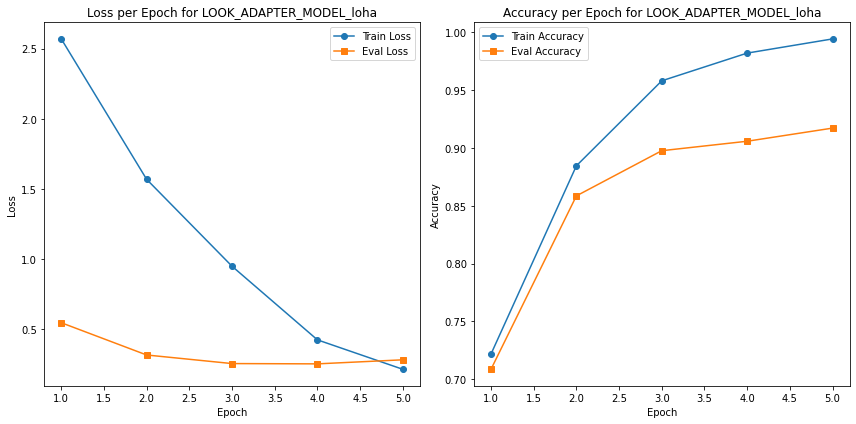

{'eval_loss': 0.28264889121055603, 'eval_accuracy': 0.9172727272727272, 'eval_f1': 0.9172138319433643, 'eval_precision': 0.917278676772933, 'eval_recall': 0.9172727272727272, 'eval_runtime': 37.0713, 'eval_samples_per_second': 59.345, 'eval_steps_per_second': 0.944, 'epoch': 4.927536231884058}

Training LOOK_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 40,706/85,840,900 (0.05%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 2.5906, 'grad_norm': 0.894642174243927, 'learning_rate': 0.0017000000000000001, 'epoch': 0.9855072463768116}
{'eval_loss': 0.5626120567321777, 'eval_accuracy': 0.7009090909090909, 'eval_f1': 0.6862857351480905, 'eval_precision': 0.72209014329966, 'eval_recall': 0.7009090909090909, 'eval_runtime': 37.2487, 'eval_samples_per_second': 59.062, 'eval_steps_per_second': 0.94, 'epoch': 0.9855072463768116}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.8727, 'grad_norm': 0.9273878931999207, 'learning_rate': 0.0034000000000000002, 'epoch': 2.0}
{'eval_loss': 0.4005821645259857, 'eval_accuracy': 0.8059090909090909, 'eval_f1': 0.8054258265810922, 'eval_precision': 0.8058877856477461, 'eval_recall': 0.8059090909090909, 'eval_runtime': 37.1292, 'eval_samples_per_second': 59.253, 'eval_steps_per_second': 0.943, 'epoch': 2.0}
Starting Epoc

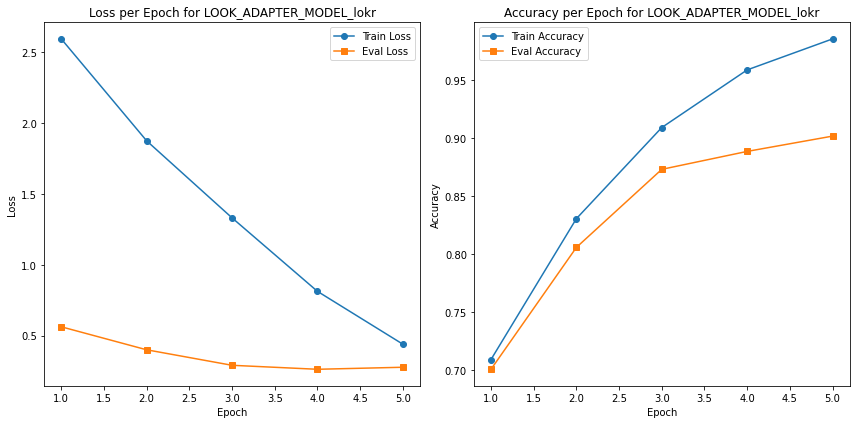

{'eval_loss': 0.27760422229766846, 'eval_accuracy': 0.9018181818181819, 'eval_f1': 0.9013899674405207, 'eval_precision': 0.9035185440464951, 'eval_recall': 0.9018181818181819, 'eval_runtime': 37.7349, 'eval_samples_per_second': 58.302, 'eval_steps_per_second': 0.928, 'epoch': 4.927536231884058}

Training OCCLUSION_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 444,675/86,245,638 (0.52%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 3.9814, 'grad_norm': 1.9911173582077026, 'learning_rate': 0.00145, 'epoch': 0.9747899159663865}
{'eval_loss': 0.7982741594314575, 'eval_accuracy': 0.621578947368421, 'eval_f1': 0.5910955015403159, 'eval_precision': 0.6022970037293661, 'eval_recall': 0.621578947368421, 'eval_runtime': 34.1579, 'eval_samples_per_second': 55.624, 'eval_steps_per_second': 0.878, 'epoch': 0.9747899159663865}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 2.6043, 'grad_norm': 2.145029306411743, 'learning_rate': 0.00295, 'epoch': 1.9831932773109244}
{'eval_loss': 0.5762618184089661, 'eval_accuracy': 0.7289473684210527, 'eval_f1': 0.7163315902852144, 'eval_precision': 0.737606681579376, 'eval_recall': 0.7289473684210527, 'eval_runtime': 32.1819, 'eval_samples_per_second': 59.039, 'eval_steps_per_second': 0.932, 'epoch': 1.9831932773109244}
Starting E

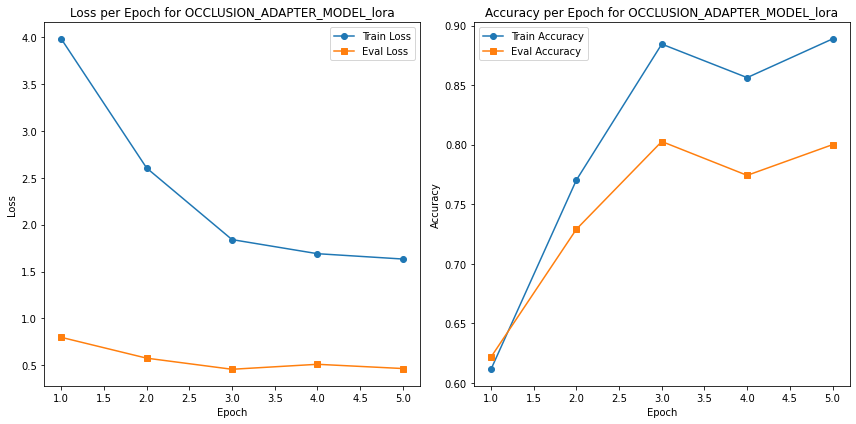

{'eval_loss': 0.45761948823928833, 'eval_accuracy': 0.8026315789473685, 'eval_f1': 0.8002713108281495, 'eval_precision': 0.7993463555709095, 'eval_recall': 0.8026315789473685, 'eval_runtime': 32.0991, 'eval_samples_per_second': 59.192, 'eval_steps_per_second': 0.935, 'epoch': 4.873949579831933}

Training OCCLUSION_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 444,963/86,245,962 (0.52%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.2668, 'grad_norm': 1.6016789674758911, 'learning_rate': 0.00145, 'epoch': 0.9747899159663865}
{'eval_loss': 0.9245932102203369, 'eval_accuracy': 0.5805263157894737, 'eval_f1': 0.5262842289432503, 'eval_precision': 0.5816715651715012, 'eval_recall': 0.5805263157894737, 'eval_runtime': 32.5923, 'eval_samples_per_second': 58.296, 'eval_steps_per_second': 0.92, 'epoch': 0.9747899159663865}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.0338, 'grad_norm': 1.237536907196045, 'learning_rate': 0.0029, 'epoch': 1.9831932773109244}
{'eval_loss': 0.6430376172065735, 'eval_accuracy': 0.6873684210526316, 'eval_f1': 0.6689700522176241, 'eval_precision': 0.7001032753864861, 'eval_recall': 0.6873684210526316, 'eval_runtime': 32.8254, 'eval_samples_per_second': 57.882, 'eval_steps_per_second': 0.914, 'epoch': 1.9831932773109244}
Starti

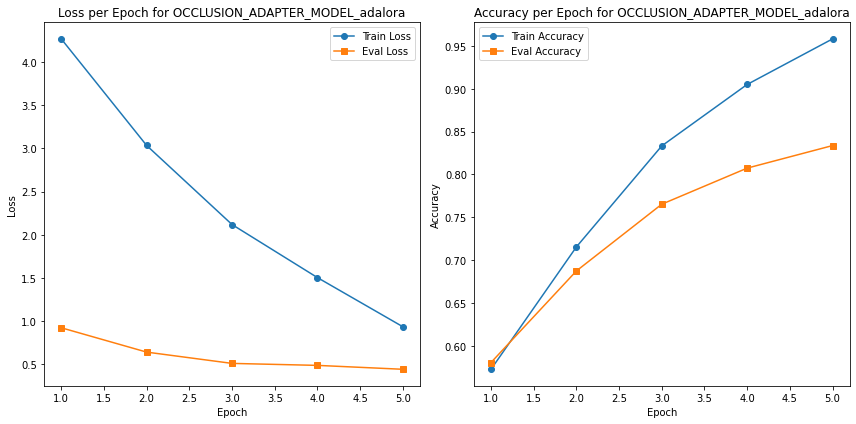

{'eval_loss': 0.44436949491500854, 'eval_accuracy': 0.8336842105263158, 'eval_f1': 0.8355063395801058, 'eval_precision': 0.8402168268109755, 'eval_recall': 0.8336842105263158, 'eval_runtime': 32.6072, 'eval_samples_per_second': 58.269, 'eval_steps_per_second': 0.92, 'epoch': 4.873949579831933}

Training OCCLUSION_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 85,251/85,886,214 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.2402, 'grad_norm': 1.7521705627441406, 'learning_rate': 0.00145, 'epoch': 0.9747899159663865}
{'eval_loss': 0.9119495153427124, 'eval_accuracy': 0.5952631578947368, 'eval_f1': 0.5500766670146019, 'eval_precision': 0.5986494289736325, 'eval_recall': 0.5952631578947368, 'eval_runtime': 32.8299, 'eval_samples_per_second': 57.874, 'eval_steps_per_second': 0.914, 'epoch': 0.9747899159663865}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.1557, 'grad_norm': 1.168844223022461, 'learning_rate': 0.00295, 'epoch': 1.9831932773109244}
{'eval_loss': 0.7017796635627747, 'eval_accuracy': 0.6657894736842105, 'eval_f1': 0.6511476421295108, 'eval_precision': 0.6503301245134422, 'eval_recall': 0.6657894736842105, 'eval_runtime': 32.7791, 'eval_samples_per_second': 57.964, 'eval_steps_per_second': 0.915, 'epoch': 1.9831932773109244}
Starting 

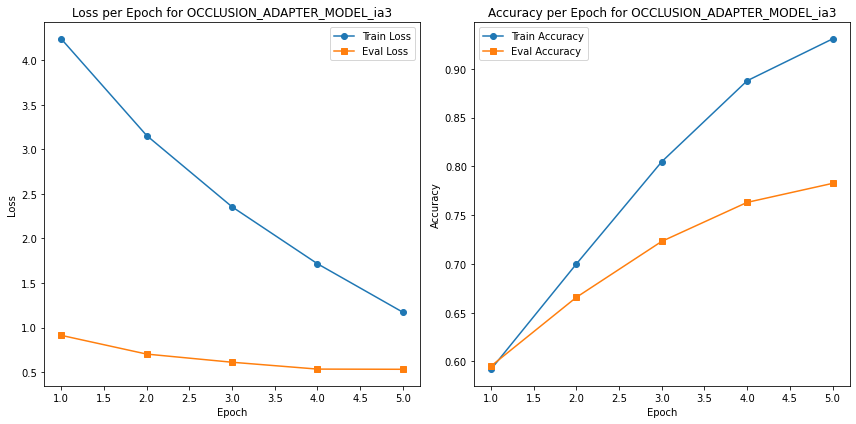

{'eval_loss': 0.5311185717582703, 'eval_accuracy': 0.7826315789473685, 'eval_f1': 0.7841192736891062, 'eval_precision': 0.7958491211227674, 'eval_recall': 0.7826315789473685, 'eval_runtime': 32.965, 'eval_samples_per_second': 57.637, 'eval_steps_per_second': 0.91, 'epoch': 4.873949579831933}

Training OCCLUSION_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 887,043/86,688,006 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.2566, 'grad_norm': 1.6153215169906616, 'learning_rate': 0.00145, 'epoch': 0.9747899159663865}
{'eval_loss': 0.9187837839126587, 'eval_accuracy': 0.5894736842105263, 'eval_f1': 0.5399056554486769, 'eval_precision': 0.5963440473460655, 'eval_recall': 0.5894736842105263, 'eval_runtime': 33.3555, 'eval_samples_per_second': 56.962, 'eval_steps_per_second': 0.899, 'epoch': 0.9747899159663865}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.0362, 'grad_norm': 0.8692107200622559, 'learning_rate': 0.00295, 'epoch': 1.9831932773109244}
{'eval_loss': 0.6591169238090515, 'eval_accuracy': 0.6905263157894737, 'eval_f1': 0.6863257150976158, 'eval_precision': 0.7018663018833026, 'eval_recall': 0.6905263157894737, 'eval_runtime': 32.6711, 'eval_samples_per_second': 58.155, 'eval_steps_per_second': 0.918, 'epoch': 1.9831932773109244}
Starti

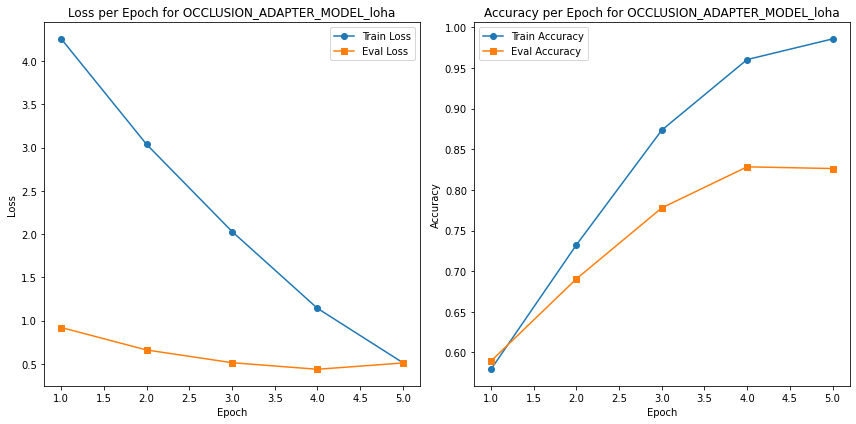

{'eval_loss': 0.43598678708076477, 'eval_accuracy': 0.828421052631579, 'eval_f1': 0.8265179558423116, 'eval_precision': 0.8257314112496732, 'eval_recall': 0.828421052631579, 'eval_runtime': 32.8144, 'eval_samples_per_second': 57.901, 'eval_steps_per_second': 0.914, 'epoch': 4.873949579831933}

Training OCCLUSION_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 41,475/85,842,438 (0.05%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.2582, 'grad_norm': 1.6315953731536865, 'learning_rate': 0.00145, 'epoch': 0.9747899159663865}
{'eval_loss': 0.9297680854797363, 'eval_accuracy': 0.5647368421052632, 'eval_f1': 0.4849928924153624, 'eval_precision': 0.6055226997958927, 'eval_recall': 0.5647368421052632, 'eval_runtime': 32.2491, 'eval_samples_per_second': 58.916, 'eval_steps_per_second': 0.93, 'epoch': 0.9747899159663865}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.3084, 'grad_norm': 0.9901262521743774, 'learning_rate': 0.00295, 'epoch': 1.9831932773109244}
{'eval_loss': 0.7375043034553528, 'eval_accuracy': 0.6589473684210526, 'eval_f1': 0.6457666690203042, 'eval_precision': 0.6449359938194232, 'eval_recall': 0.6589473684210526, 'eval_runtime': 32.2287, 'eval_samples_per_second': 58.954, 'eval_steps_per_second': 0.931, 'epoch': 1.9831932773109244}
Starting

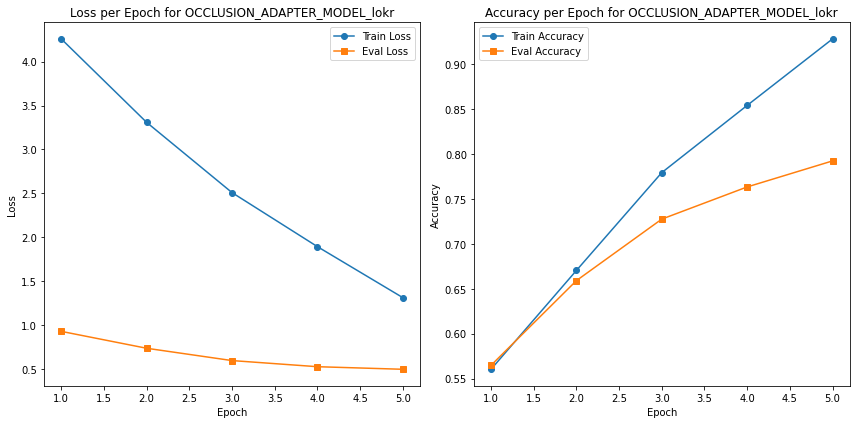

{'eval_loss': 0.4982844591140747, 'eval_accuracy': 0.7921052631578948, 'eval_f1': 0.7930815510285526, 'eval_precision': 0.7946248420135159, 'eval_recall': 0.7921052631578948, 'eval_runtime': 32.3816, 'eval_samples_per_second': 58.675, 'eval_steps_per_second': 0.926, 'epoch': 4.873949579831933}


In [21]:
results = {}
for adapter_type in config_ped.keys():
    for lora_type in adapter_configs.keys():
        print(f"\nTraining {adapter_type} with {lora_type} type...")
        metrics = train_model_with_adapter(adapter_type, lora_type)
        results[f"{adapter_type}_{lora_type}"] = metrics


In [22]:
results

{'ACTION_ADAPTER_MODEL_lora': {'eval_loss': 0.19939997792243958,
  'eval_accuracy': 0.9188888888888889,
  'eval_f1': 0.9189572395774116,
  'eval_precision': 0.9191081943825432,
  'eval_recall': 0.9188888888888889,
  'eval_runtime': 30.9089,
  'eval_samples_per_second': 58.236,
  'eval_steps_per_second': 0.938,
  'epoch': 4.95575221238938},
 'ACTION_ADAPTER_MODEL_adalora': {'eval_loss': 0.1804492175579071,
  'eval_accuracy': 0.94,
  'eval_f1': 0.9402057303477181,
  'eval_precision': 0.9427944551000887,
  'eval_recall': 0.94,
  'eval_runtime': 31.2309,
  'eval_samples_per_second': 57.635,
  'eval_steps_per_second': 0.929,
  'epoch': 4.95575221238938},
 'ACTION_ADAPTER_MODEL_ia3': {'eval_loss': 0.16220825910568237,
  'eval_accuracy': 0.9411111111111111,
  'eval_f1': 0.9411607355836004,
  'eval_precision': 0.94129502859696,
  'eval_recall': 0.9411111111111111,
  'eval_runtime': 31.3814,
  'eval_samples_per_second': 57.359,
  'eval_steps_per_second': 0.924,
  'epoch': 4.95575221238938},
 'A

In [23]:
def display_results_as_table(results):
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = {
            "Adapter": adapter_type,
            "LoRA Type": lora_type,
            "Eval Loss": metrics.get("eval_loss", None),
            "Eval Accuracy": metrics.get("eval_accuracy", None),
            "Eval F1": metrics.get("eval_f1", None),
            "Eval Precision": metrics.get("eval_precision", None),
            "Eval Recall": metrics.get("eval_recall", None),
            "Epoch": metrics.get("epoch", None)
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["Adapter", "LoRA Type"])
    print("\n=== Comparison of All Adapter and LoRA Models ===")
    print(df.to_string(index=False))

display_results_as_table(results)


=== Comparison of All Adapter and LoRA Models ===
  Adapter             LoRA Type  Eval Loss  Eval Accuracy  Eval F1  Eval Precision  Eval Recall    Epoch
   ACTION ADAPTER_MODEL_adalora   0.180449       0.940000 0.940206        0.942794     0.940000 4.955752
   ACTION     ADAPTER_MODEL_ia3   0.162208       0.941111 0.941161        0.941295     0.941111 4.955752
   ACTION    ADAPTER_MODEL_loha   0.181444       0.948889 0.949019        0.950188     0.948889 4.955752
   ACTION    ADAPTER_MODEL_lokr   0.169233       0.941111 0.941292        0.943173     0.941111 4.955752
   ACTION    ADAPTER_MODEL_lora   0.199400       0.918889 0.918957        0.919108     0.918889 4.955752
    CROSS ADAPTER_MODEL_adalora   0.218190       0.920306 0.920035        0.920295     0.920306 4.892086
    CROSS     ADAPTER_MODEL_ia3   0.269341       0.901846 0.902059        0.902563     0.901846 4.892086
    CROSS    ADAPTER_MODEL_loha   0.269088       0.914903 0.915432        0.919764     0.914903 4.892086
    

# Best Results

| **Adapter**              | **LoRA Type**          | **Eval Loss** | **Eval Accuracy** | **Eval F1**   | **Eval Precision** | **Eval Recall** | **Epoch**   |
|--------------------------|------------------------|---------------|-------------------|---------------|--------------------|-----------------|-------------|
| ACTION_ADAPTER_MODEL    | loha     | 0.181444      | 0.948889          | 0.949019      | 0.950188           | 0.948889        | 4.955752    |
| CROSS_ADAPTER_MODEL     | adalora  | 0.218190      | 0.920306          | 0.920035      | 0.920295           | 0.920306        | 4.892086    |
| LOOK_ADAPTER_MODEL      | loha     | 0.282649      | 0.917273          | 0.917214      | 0.917279           | 0.917273        | 4.927536    |
| OCCLUSION_ADAPTER_MODEL | adalora  | 0.444369      | 0.833684          | 0.835506      | 0.840217           | 0.833684        | 4.873950    |

In [24]:
def save_results_to_csv(results, file_path):
    header = ['Adapter Model', 'LoRA Type', 'Eval Loss', 'Eval Accuracy', 'Eval F1', 'Eval Precision', 'Eval Recall', 'Epoch']
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = [adapter_type, lora_type]
        row.append(metrics.get('eval_loss', None))
        row.append(metrics.get('eval_accuracy', None))
        row.append(metrics.get('eval_f1', None))
        row.append(metrics.get('eval_precision', None))
        row.append(metrics.get('eval_recall', None))
        row.append(metrics.get('epoch', None))
        rows.append(row)
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  
        writer.writerows(rows)   

file_path = 'ped_behavior_results.csv'
save_results_to_csv(results, file_path)

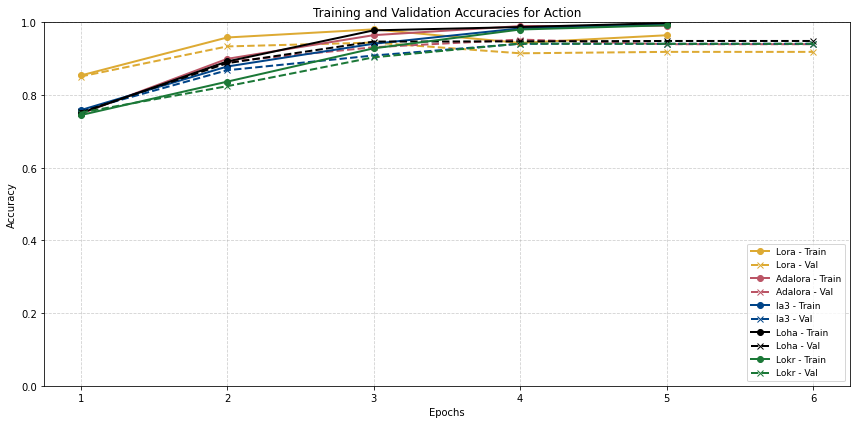

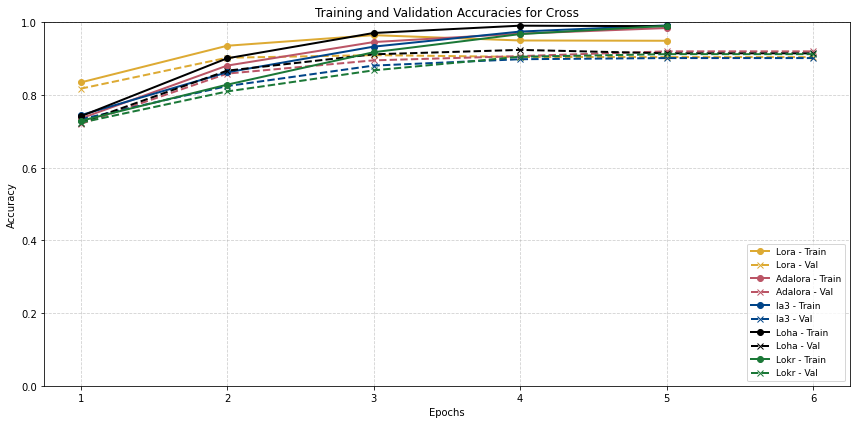

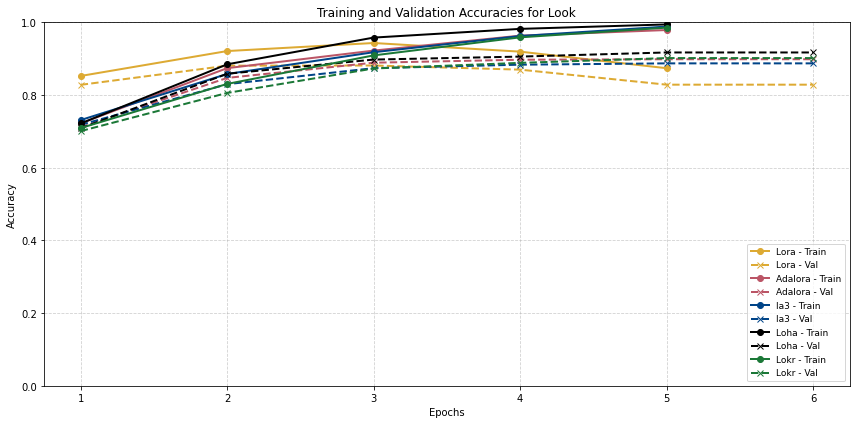

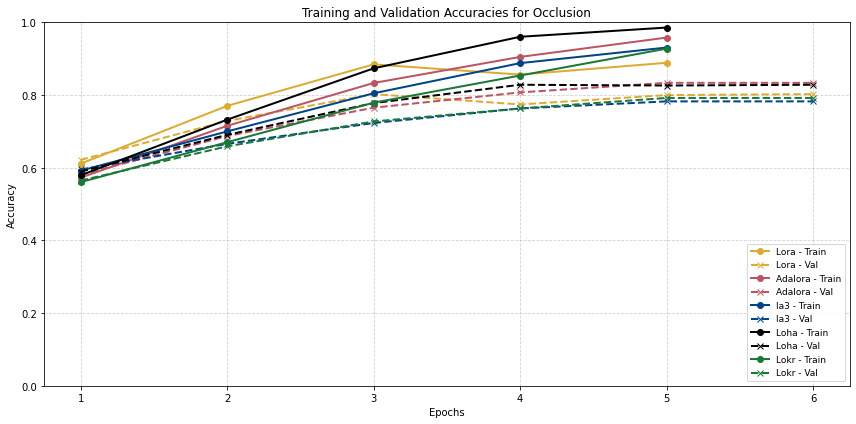

In [25]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837', '#117733', '#88CCEE']

def plot_accuracies_per_epoch(metrics_storage):
    max_epochs = max(
        max(len(metrics.get('train_accuracy', [])), len(metrics.get('eval_accuracy', [])))
        for lora_metrics in metrics_storage.values() for metrics in lora_metrics.values()
    )
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6)) 
        for i, (lora_type, metrics) in enumerate(lora_metrics.items()):
            train_accuracies = metrics.get('train_accuracy', [])
            val_accuracies = metrics.get('eval_accuracy', [])
            train_accuracies = np.array(train_accuracies + [np.nan] * (max_epochs - len(train_accuracies)))
            val_accuracies = np.array(val_accuracies + [np.nan] * (max_epochs - len(val_accuracies)))
            epochs = np.arange(1, max_epochs + 1)  # Epoch numbers
            ax.plot(epochs, train_accuracies, marker='o', linestyle='-', 
                    label=f'{lora_type.capitalize()} - Train', 
                    color=colors[i % len(colors)], linewidth=2)

            ax.plot(epochs, val_accuracies, marker='x', linestyle='--', 
                    label=f'{lora_type.capitalize()} - Val', 
                    color=colors[i % len(colors)], linewidth=2)

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1) 
        ax.set_title(f'Training and Validation Accuracies for {adapter_name.replace("_ADAPTER_MODEL", "").replace("_", " ").title()}')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

plot_accuracies_per_epoch(metrics_storage)

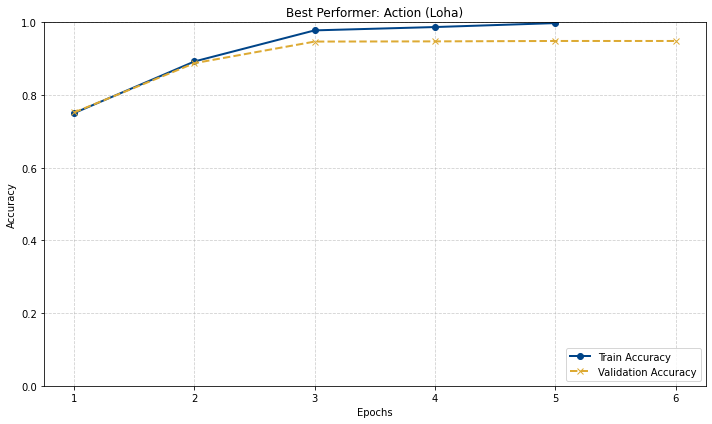

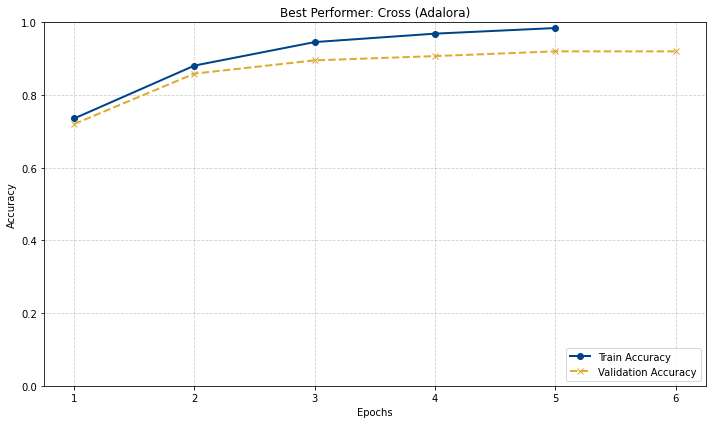

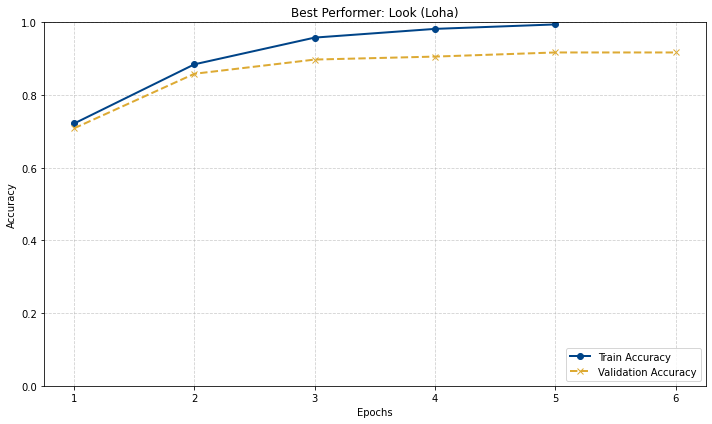

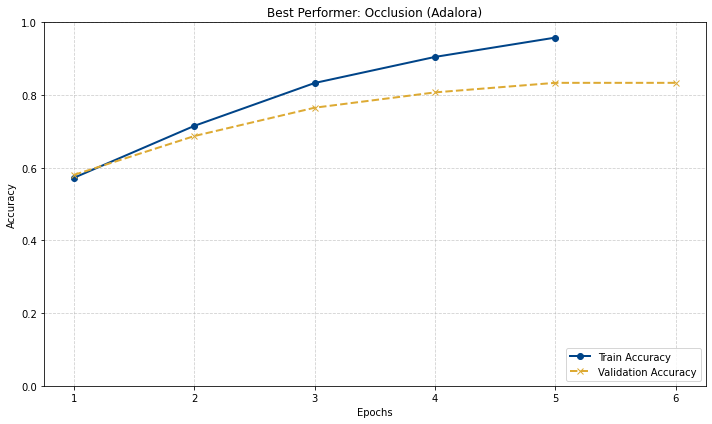

In [26]:
def plot_best_performer(metrics_storage, results, metric="Eval Accuracy"):
    """
    Plots the training and validation accuracies per epoch for the best performer in each adapter model.
    
    Args:
    - metrics_storage: Dictionary containing training and validation metrics for all adapters and LoRA types.
    - results: Dictionary containing final evaluation metrics for all adapter and LoRA models.
    - metric: Metric to determine the best performer (e.g., "Eval Accuracy").
    """
    best_performers = {}
    
    # Identify the best performer for each adapter
    for model_adapter, metrics in results.items():
        # Safely split on "_ADAPTER_MODEL" to avoid duplication
        if "_ADAPTER_MODEL" in model_adapter:
            adapter_type, lora_type = model_adapter.split("_ADAPTER_MODEL", 1)
            adapter_type = adapter_type.strip()  # Clean up extra spaces
            lora_type = lora_type.replace("_", "").strip()  # Clean up extra spaces or underscores
        else:
            raise ValueError(f"Unexpected model_adapter format: {model_adapter}")
        
        eval_metric = metrics.get(metric.lower().replace(" ", "_"), 0)
        
        if adapter_type not in best_performers or eval_metric > best_performers[adapter_type]["metric"]:
            best_performers[adapter_type] = {
                "lora_type": lora_type,
                "metric": eval_metric
            }
    
    # Plot metrics for each best performer
    for adapter_name, best in best_performers.items():
        lora_type = best["lora_type"]
        # Correct key handling for metrics_storage
        full_adapter_name = f"{adapter_name}_ADAPTER_MODEL"

        if full_adapter_name not in metrics_storage:
            raise KeyError(f"{full_adapter_name} not found in metrics_storage.")
        
        metrics = metrics_storage[full_adapter_name][lora_type]
        max_epochs = max(len(metrics["train_accuracy"]), len(metrics["eval_accuracy"]))
        
        train_accuracies = np.array(metrics["train_accuracy"] + [np.nan] * (max_epochs - len(metrics["train_accuracy"])))
        val_accuracies = np.array(metrics["eval_accuracy"] + [np.nan] * (max_epochs - len(metrics["eval_accuracy"])))
        epochs = np.arange(1, max_epochs + 1)  # Epoch numbers
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_accuracies, marker='o', linestyle='-', label='Train Accuracy', linewidth=2, color='#004488')
        plt.plot(epochs, val_accuracies, marker='x', linestyle='--', label='Validation Accuracy', linewidth=2, color='#DDAA33')
        
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.title(f'Best Performer: {adapter_name.replace("_", " ").title()} ({lora_type.capitalize()})')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

# Call the function to plot
plot_best_performer(metrics_storage, results, metric="Eval Accuracy")


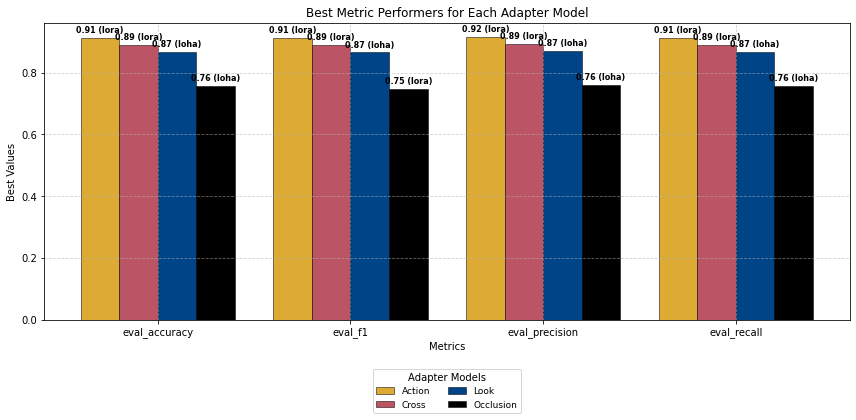

In [27]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

def get_best_performers(metrics_storage, metric_labels):
    """
    Extracts the best performer for each metric across LoRA types for each adapter.

    Args:
    - metrics_storage: Nested dictionary with adapter models and their LoRA metrics.
    - metric_labels: List of metric labels to compare.

    Returns:
    - best_metrics: Dictionary with the best metric values and corresponding LoRA types for each adapter.
    """
    best_metrics = {}

    # Loop through each adapter model
    for adapter_name, lora_metrics in metrics_storage.items():
        best_metrics[adapter_name] = {}

        # Loop through each metric to find the best performer
        for metric in metric_labels:
            best_value = -np.inf  # Initialize to a very small number
            best_lora_type = None

            # Check all LoRA types for the current metric
            for lora_type, metrics in lora_metrics.items():
                # Calculate the mean if the metric value is a list
                value = np.mean(metrics.get(metric, 0)) if isinstance(metrics.get(metric, 0), list) else metrics.get(metric, 0)

                # Update the best value if a higher one is found
                if value > best_value:
                    best_value = value
                    best_lora_type = lora_type

            # Store the best value and the LoRA type that achieved it
            best_metrics[adapter_name][metric] = (best_value, best_lora_type)

    return best_metrics

def plot_best_performers(best_metrics, metric_labels):
    """
    Plots the best metric values for each adapter model with LoRA type annotations.

    Args:
    - best_metrics: Dictionary containing the best metric values and their LoRA types for each adapter.
    - metric_labels: List of metric labels to display on the x-axis.
    """
    # Define bar width and positions
    bar_width = 0.2
    index = np.arange(len(metric_labels))  # X-axis positions for metrics

    # Number of adapter models
    n_adapters = len(best_metrics)

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars for each adapter model
    for i, (adapter_name, metrics) in enumerate(best_metrics.items()):
        # Extract metric values and corresponding LoRA types
        metric_values = [metrics[metric][0] for metric in metric_labels]
        lora_types = [metrics[metric][1] for metric in metric_labels]

        # Calculate bar positions for this adapter
        adjusted_index = index + i * bar_width

        # Plot bars with custom colors
        bars = ax.bar(
            adjusted_index, metric_values, bar_width,
            label=adapter_name.replace('_ADAPTER_MODEL', '').replace('_', ' ').title(),
            color=colors[i % len(colors)], edgecolor='black', linewidth=0.5
        )

        # Annotate bars with metric values and LoRA types
        for bar, value, lora_type in zip(bars, metric_values, lora_types):
            yval = round(value, 2)
            ax.text(
                bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{yval} ({lora_type})", ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Best Values')
    ax.set_title('Best Metric Performers for Each Adapter Model')
    ax.set_xticks(index + bar_width * (n_adapters - 1) / 2)
    ax.set_xticklabels(metric_labels)

    # Add legend at the bottom
    ax.legend(title='Adapter Models', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Define the metric labels you want to visualize
metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]

# Step 1: Extract the best performers for each metric
best_metrics = get_best_performers(metrics_storage, metric_labels)

# Step 2: Plot the best performers for each adapter model
plot_best_performers(best_metrics, metric_labels)


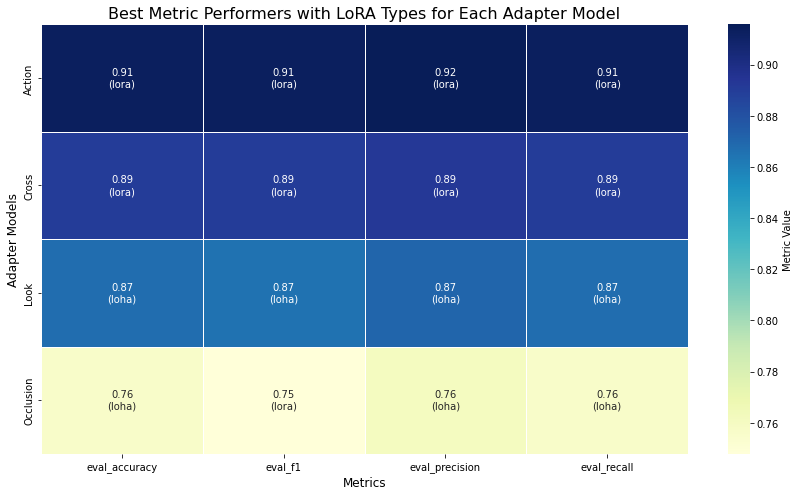

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_heatmap_with_lora_types(best_metrics, metric_labels):
    """
    Plots a heatmap for the best-performing metrics, with LoRA type annotations.

    Args:
    - best_metrics: Dictionary with the best metric values and their LoRA types.
    - metric_labels: List of metric labels to display on the axes.
    """
    # Prepare data for the heatmap
    data = []
    annotations = []  # Store annotations for LoRA type

    for adapter_name, metrics in best_metrics.items():
        row = []
        row_annotations = []

        # Extract metric values and LoRA types
        for metric in metric_labels:
            value, lora_type = metrics[metric]
            row.append(value)
            row_annotations.append(f"{round(value, 2)}\n({lora_type})")  # Value + LoRA type

        data.append(row)
        annotations.append(row_annotations)

    # Convert the data into a DataFrame
    df = pd.DataFrame(data, index=[adapter_name.replace('_ADAPTER_MODEL', '').replace('_', ' ').title() for adapter_name in best_metrics.keys()], columns=metric_labels)

    # Create the heatmap using seaborn
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(df, annot=annotations, fmt="", cmap='YlGnBu', 
                     linewidths=0.5, cbar_kws={'label': 'Metric Value'})

    # Add titles and labels
    plt.title('Best Metric Performers with LoRA Types for Each Adapter Model', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Adapter Models', fontsize=12)

    # Adjust layout and display the heatmap
    plt.tight_layout()
    plt.show()

# Call the function
plot_heatmap_with_lora_types(best_metrics, metric_labels)


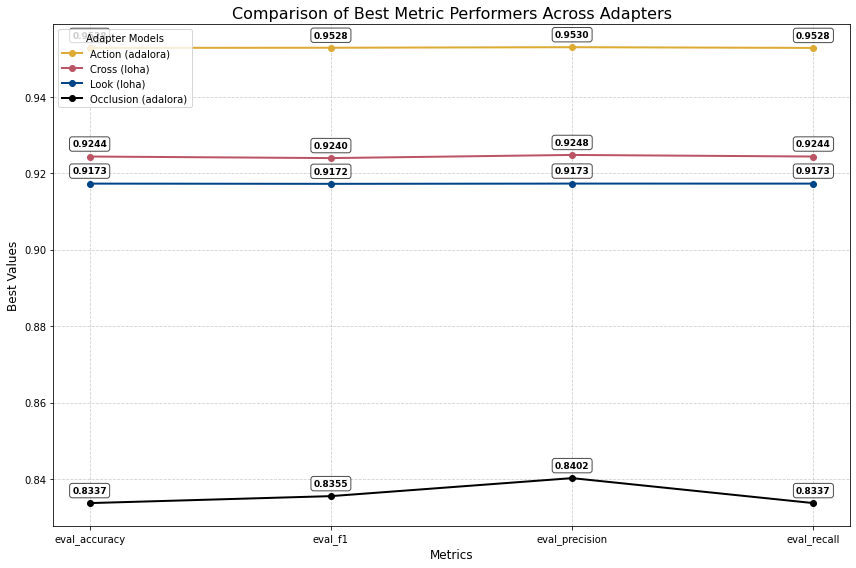

In [29]:
def get_best_metrics(metrics_storage, metric_labels):
    """
    Extracts the best overall metric values and corresponding LoRA types for each adapter.

    Args:
    - metrics_storage: Nested dictionary with adapter models and their LoRA metrics.
    - metric_labels: List of metric labels to compare.

    Returns:
    - best_metrics: Dictionary with the best overall metric values and corresponding LoRA types for each adapter.
    """
    best_metrics = {}

    for adapter_name, lora_metrics in metrics_storage.items():
        best_metrics[adapter_name] = {"lora_type": None, "metrics": {}}
        best_value = -np.inf
        best_lora_type = None

        # Find the best LoRA type based on the first metric in metric_labels
        for lora_type, metrics in lora_metrics.items():
            metric_values = metrics.get(metric_labels[0].lower(), [])
            if metric_values:
                max_value = max(metric_values)
                if max_value > best_value:
                    best_value = max_value
                    best_lora_type = lora_type

        # Store the best LoRA type and its corresponding metrics
        best_metrics[adapter_name]["lora_type"] = best_lora_type
        for metric in metric_labels:
            metric_values = lora_metrics[best_lora_type].get(metric.lower(), [])
            best_metrics[adapter_name]["metrics"][metric] = max(metric_values) if metric_values else None

    return best_metrics


def plot_comparison_of_best_performers(best_metrics, metric_labels):
    """
    Plots a comparative line chart showing the best metric values for each adapter
    with LoRA annotations for the best LoRA type.

    Args:
    - best_metrics: Dictionary with the best metric values and their LoRA types for each adapter.
    - metric_labels: List of metric labels to display on the x-axis.
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for each adapter (provided list)
    colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

    # Loop through each adapter to add its line to the plot
    for i, (adapter_name, data) in enumerate(best_metrics.items()):
        # Extract data for the adapter
        lora_type = data["lora_type"]
        values = [data["metrics"][metric] for metric in metric_labels]

        # Plot the line with markers
        ax.plot(
            metric_labels, values, marker='o',
            label=f"{adapter_name.replace('_ADAPTER_MODEL', '').title()} ({lora_type})",
            linewidth=2, color=colors[i % len(colors)]  # Use specified colors
        )

        # Annotate each point with the corresponding metric value
        for idx, (x, y) in enumerate(zip(metric_labels, values)):
            if y is not None:
                ax.annotate(
                    f"{y:.4f}",
                    xy=(x, y),  # Position of the marker
                    xytext=(0, 10),  # Offset from the marker
                    textcoords='offset points',  # Use offset points for placement
                    fontsize=9, fontweight='bold', ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
                )

    # Add labels, title, and legend
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Best Values', fontsize=12)
    ax.set_title('Comparison of Best Metric Performers Across Adapters', fontsize=16)
    ax.legend(title='Adapter Models', loc='upper left', fontsize=10)

    # Adjust grid and layout
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    
metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
best_metrics = get_best_metrics(metrics_storage, metric_labels)
plot_comparison_of_best_performers(best_metrics, metric_labels)


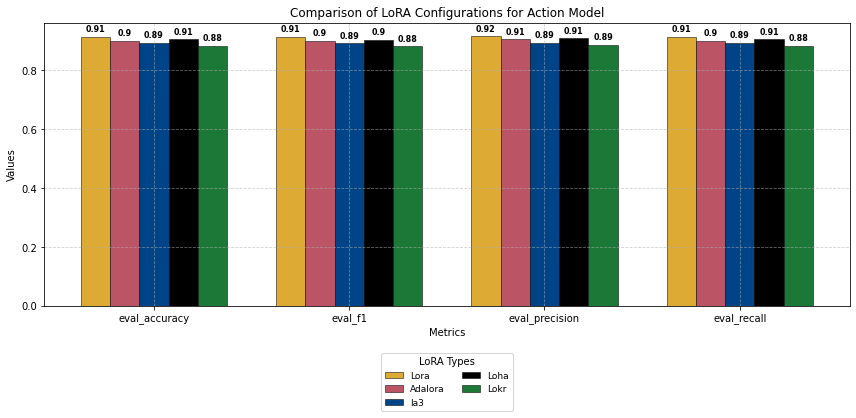

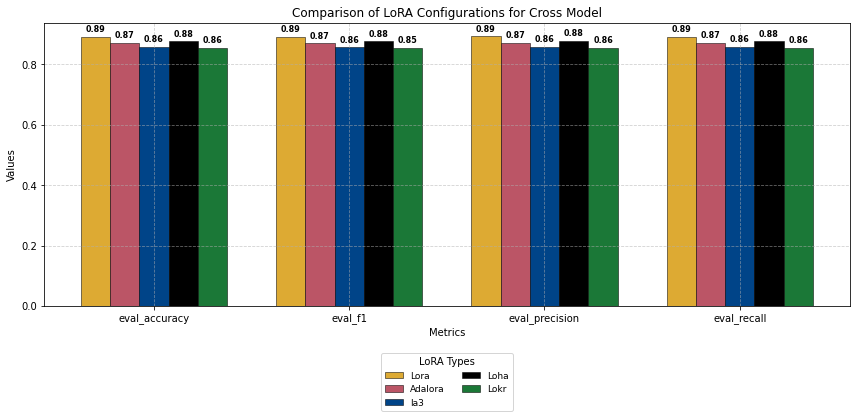

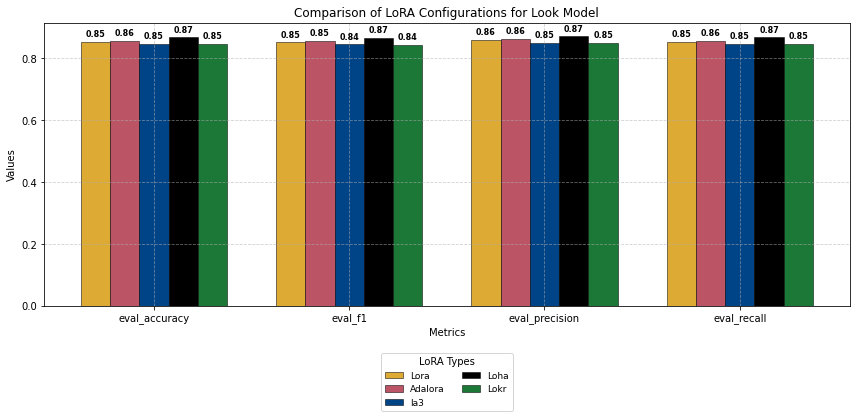

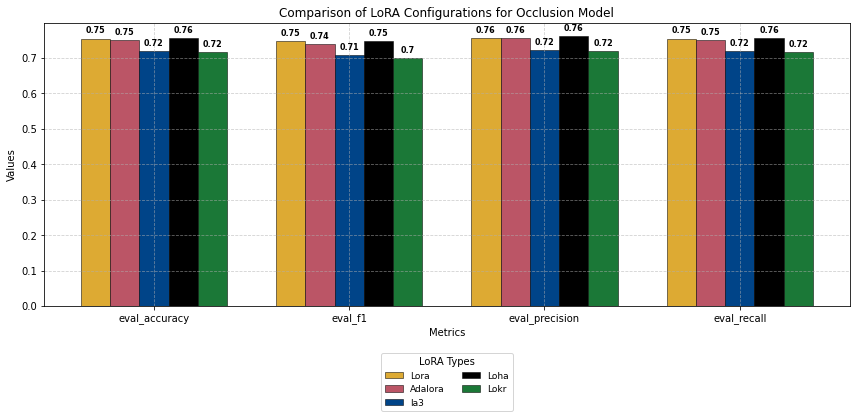

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_per_adapter(metrics_storage, metric_labels):
    display_names = {
        "ACTION_ADAPTER_MODEL": "Action Model",
        "CROSS_ADAPTER_MODEL": "Cross Model",
        "LOOK_ADAPTER_MODEL": "Look Model",
        "OCCLUSION_ADAPTER_MODEL": "Occlusion Model"
    }
    colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']
    while len(colors) < len(adapter_configs):
        colors += colors  

    bar_width = 0.15  
    n_metrics = len(metric_labels)
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6)) 

        lora_names = list(lora_metrics.keys())  
        n_lora_types = len(lora_names) 

        index = np.arange(n_metrics) 
        for i, lora_type in enumerate(lora_names):
            metric_values = [
                np.mean(lora_metrics[lora_type].get(metric, [0])) for metric in metric_labels
            ]
            bars = ax.bar(
                index + i * bar_width, metric_values, bar_width,
                label=lora_type.capitalize(),
                color=colors[i % len(colors)], edgecolor='black', linewidth=0.5
            )
            for bar, value in zip(bars, metric_values):
                yval = round(value, 2)
                ax.text(
                    bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    yval, ha='center', va='bottom', fontsize=8, fontweight='bold'
                )
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_title(f'Comparison of LoRA Configurations for {display_names.get(adapter_name, adapter_name)}')
        ax.set_xticks(index + bar_width * (n_lora_types - 1) / 2)
        ax.set_xticklabels(metric_labels)
        ax.legend(title='LoRA Types', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6) 
        plt.tight_layout()
        plt.show()

metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
plot_metrics_per_adapter(metrics_storage, metric_labels)